In [1]:
# Kristina Fauss
# April 19, 2024
# model selection by AIC testing all 1st order interactions

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from ols_mixedef_custom import *

In [2]:
fp = '/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/data/processed-data/main_dataset.csv'

flamog = pd.read_csv(fp)

# drop na's for flam metrics
print(len(flamog))
for col in ['fh', 'fd', 'pfg', 'temp_change', 'heat_flux_change']:
    flamog.dropna(subset=col, inplace=True)
print(len(flamog))

flamog['plant_id']=[str(a)+'_'+str(b) for a,b in zip(flamog['plant'], flamog['species'])]

# drop hetarb - only 2 data points
flamog = flamog[flamog.species!='HETARB']
# report
print(flamog.columns)
flamog.head()

172
171
Index(['Unnamed: 0', 'species', 'plant', 'date', 'total_branch_mass',
       'total_leaf_mass', 'stem_mass_ratio', 'leaf_mass_ratio', 'leaf_lfm',
       'thickness', 'leaf_wet_mass', 'leaf_dry_mass', 'stem_lfm', 'stem_width',
       'stem_wet_mass', 'stem_dry_mass', 'stem_sav', 'lfm', 'leaf_dmc',
       'stem_dmc', 'dmc', 'leaf_area', 'leaf_sav', 'LMA', 'SLA', 'rep',
       'branch_length', 'branch_width', 'branch_height', 'sample_wt',
       'no_branches', 'mpa', 'notes_on_plant_char', 'start_time',
       'ambient_temp', 'ambient_humidity', 'pre_ignition_glow',
       'first_glow_time', 'ignition', 'primary_ignition',
       'primary_time_of_flame_end', 'secondary_ignition',
       'secondary_time_of_flame_end', 'third_ignition',
       'third_time_of_ignition_flame_end', 'time_fh', 'fh', 'time_of_glow_end',
       'end_time', 'thermocoupler_height', 'hotplate_height',
       'notes_on_flam_data', 'fd', 'tti', 'pfg', 'max_temp',
       'time_at_max_temp', 'max_temp_sensor', '

,Unnamed: 0,species,plant,date,total_branch_mass,total_leaf_mass,stem_mass_ratio,leaf_mass_ratio,leaf_lfm,thickness,...,wet_mass,dry_mass,gdw_gfw,dw_flam_sample,ww_flam_sample,branch_volume,branching,sample_density,dw_sppdev,plant_id
0,1,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.291195,4.035205,1082.04,0.416667,0.004923,0.923122,1_ARCDEN
1,2,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.429372,4.467028,1370.20,0.322581,0.004303,1.348152,1_ARCDEN
2,3,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,682.04,0.294118,0.007766,0.900752,1_ARCDEN
3,4,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,1262.25,0.466667,0.004196,0.900752,1_ARCDEN
4,5,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,0.811215,2.535185,819.00,0.500000,0.004086,-0.553297,1_ARCDEN


In [3]:
flamog.species.value_counts()

species
ERIKAR    37
SALLEU    36
CEAGRI    29
SALAPI    22
MALLAU    20
ARTCAL    13
ARCDEN     8
Name: count, dtype: int64

# Examine Correlation & Structure in Num. Var's

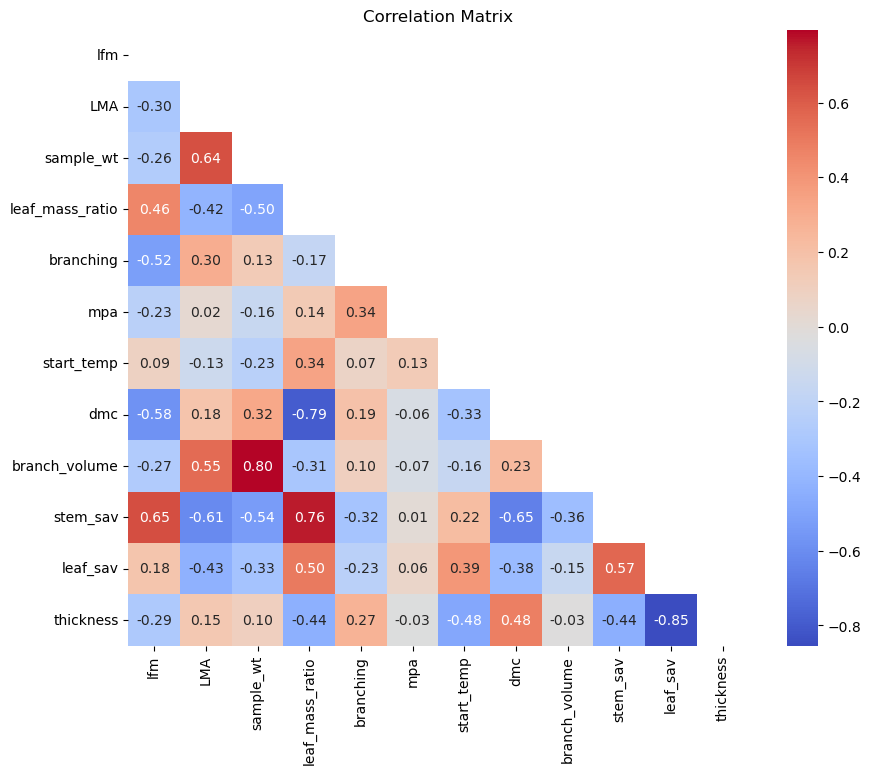

In [4]:
cols_num_use = ['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']

corrplot(flamog, cols_num_use)

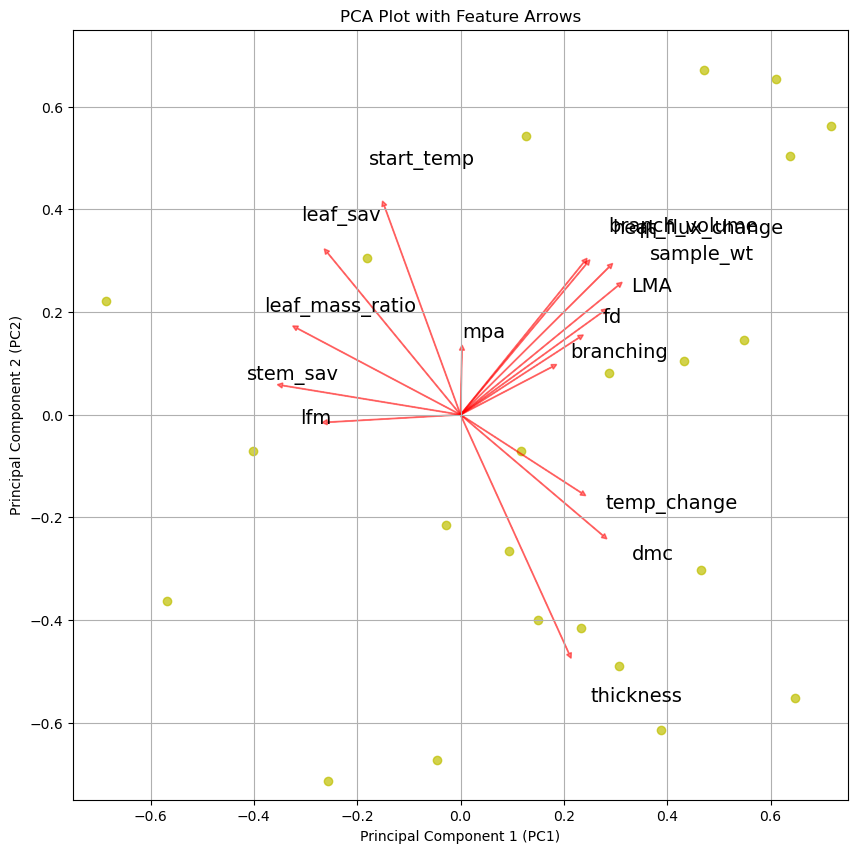

In [5]:
PCAplot(flamog, cols_num_use+['fh','fd','temp_change','heat_flux_change'])

# Modeling Preprocessing

In [6]:
# scale and center
cols_all = ['fh', 'fd', 'temp_change', 'heat_flux_change'] + cols_num_use
flam = scale_and_center(flamog, cols_all, cols_no_change=['plant_id', 'species', 'ignition'])

# declare as factors
flam['species'] = pd.Categorical(flam['species'])
flam['plant_id'] = pd.Categorical(flam['plant_id'])
flam['ignition'] = pd.Categorical(flam['ignition'])

# drop na's
print(len(flam))
cols_all_dpna = cols_all + ['plant_id', 'species', 'ignition']
flam.dropna(subset=cols_all_dpna, inplace=True)
print(len(flam))

# declare all possible IV cols to model
cols_use = cols_num_use #+ ['species']
print(cols_use)

165
158
['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']


# Run Model Selector

### NOTE: Random effect is simply `plant_id`
- NO nested effects
- NO `species'

#### It was not possible to test all combinations. Therefore, only combinations of significnt interaction terms and all singletons will be tested.

In [7]:
mxs = len(cols_use)
mns = 0
mxi = 5
mni = 0

# Flame Height

In [8]:
yvar='fh'
cols=cols_use
df=flam

compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0         thickness  364.006952 -0.035795  7.120582e-01     True
1          leaf_sav  363.918737 -0.052448  6.383973e-01     True
2               mpa  363.735106  0.050483  5.231286e-01     True
3        start_temp  362.308272  0.107725  1.736033e-01     True
4               dmc  362.239188  0.139224  1.646000e-01     True
5   leaf_mass_ratio  361.985783 -0.176500  1.380189e-01    False
6               lfm  359.193313 -0.347787  2.636709e-02    False
7          stem_sav  357.100275 -0.591178  2.478364e-07    False
8               LMA  351.291339  0.516249  1.118780e-04    False
9         branching  347.983813  0.273746  2.927882e-05    False
10    branch_volume  346.249230  0.329668  1.482620e-05    False
11        sample_wt  310.075185  0.563605  1.117563e-15    False


In [9]:
# AIC_iterator(flam, cols_use, Y_VAR='fh',
#             minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Flame Duration

In [10]:
yvar='fd'
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0               mpa  436.873240 -0.030688  7.437746e-01     True
1        start_temp  436.079075 -0.065230  5.218623e-01     True
2         thickness  435.387128  0.080096  5.179140e-01     True
3          leaf_sav  435.007152 -0.100602  3.998897e-01     True
4               LMA  434.967441  0.233946  9.034159e-02     True
5   leaf_mass_ratio  434.235530 -0.190051  5.249440e-01    False
6               lfm  433.629983 -0.229844  1.616765e-01    False
7          stem_sav  433.615000 -0.317586  6.588064e-02    False
8         branching  433.207184  0.180716  5.759355e-02    False
9     branch_volume  425.968222  0.336634  8.489578e-04    False
10              dmc  424.962442  0.402439  3.168880e-04    False
11        sample_wt  412.060412  0.487190  4.197782e-09    False


ERROR: Formula model error: fd ~ leaf_sav*thickness

Columns present in sig. interaction terms: {'sample_wt', 'dmc', 'lfm'}

Total Num. Cols : Num. Sig. Int. Cols;  12 : 3

Significant Interactions:
('sample_wt', 'dmc')
('lfm', 'sample_wt')

Number of formulas: 6659
ERROR: Formula model error: fd ~ 


fd ~ lfm*sample_wt + dmc + branch_volume
fd ~ lfm*sample_wt + leaf_mass_ratio + dmc + branch_volume
fd ~ lfm*sample_wt + dmc
fd ~ sample_wt*dmc + lfm*sample_wt + leaf_mass_ratio + branch_volume
fd ~ lfm*sample_wt + leaf_mass_ratio + mpa + dmc + branch_volume
fd ~ sample_wt*dmc + lfm*sample_wt + branch_volume
fd ~ lfm*sample_wt + mpa + dmc + branch_volume
fd ~ lfm*sample_wt + dmc + branch_volume + thickness
fd ~ lfm*sample_wt + branching + dmc + branch_volume
fd ~ lfm*sample_wt + dmc + branch_volume + leaf_sav
fd ~ lfm*sample_wt + branch_volume + leaf_sav
fd ~ sample_wt*dmc + lfm*sample_wt + leaf_mass_ratio + mpa + branch_volume
fd ~ lfm*sample_wt + leaf_mass_ratio + dmc
fd ~ lfm*sample_wt

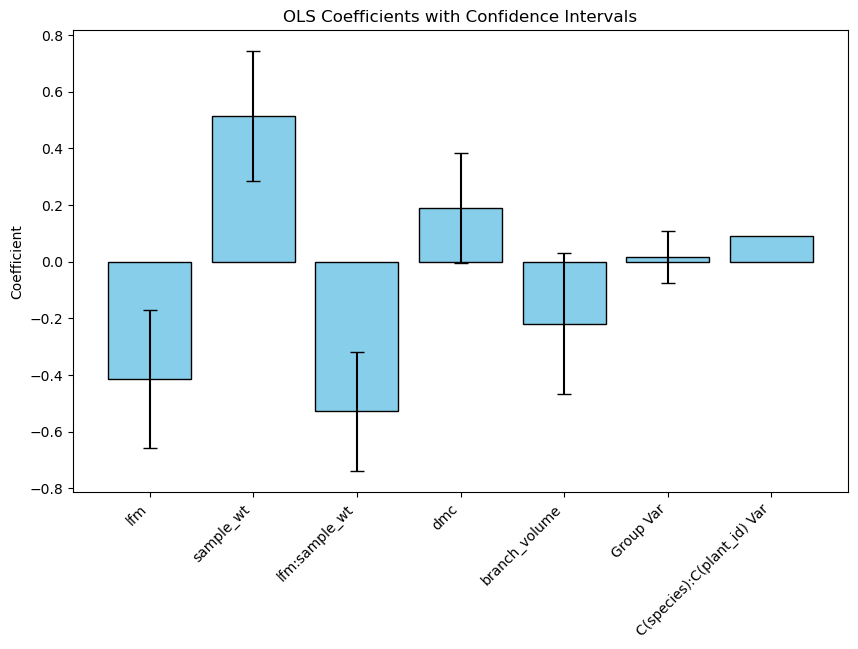

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5628   
Min. group size:        8           Log-Likelihood:         -187.3338
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.079    0.165 -0.476 0.634 -0.402  0.245
lfm                        -0.245    0.104 -2.359 0.018 -0.448 -0.041
sample_wt                   0.516    0.117  4.427 0.000  0.288  0.745
lfm:sample_wt              -0.514    0.116 -4.439 0.000 -0.741 -0.287
leaf_mass_ratio             0.225   

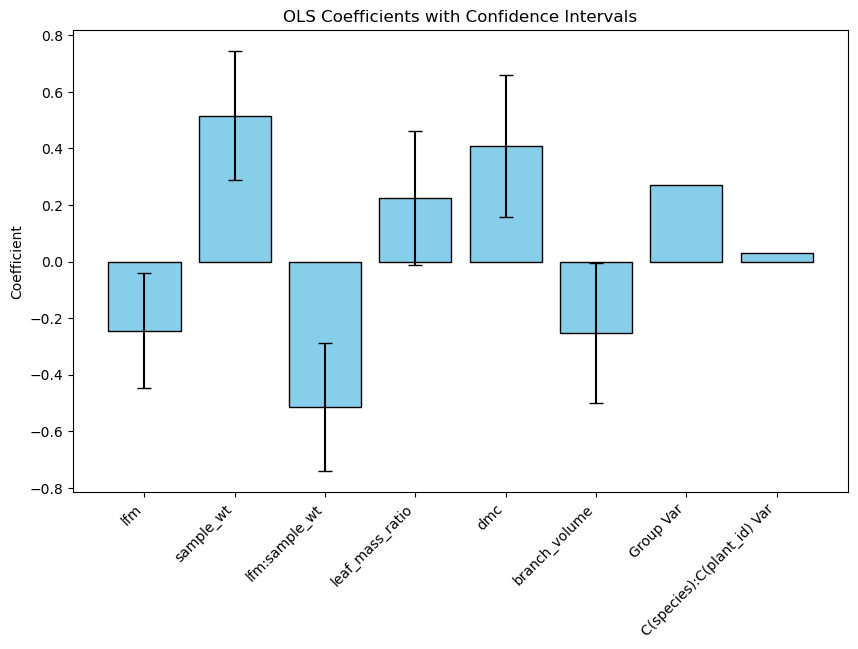

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5875   
Min. group size:        8           Log-Likelihood:         -189.4889
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.063    0.113 -0.562 0.574 -0.284  0.158
lfm                        -0.258                                    
sample_wt                   0.355    0.065  5.462 0.000  0.227  0.482
lfm:sample_wt              -0.427    0.107 -3.980 0.000 -0.637 -0.217
dmc                         0.246   

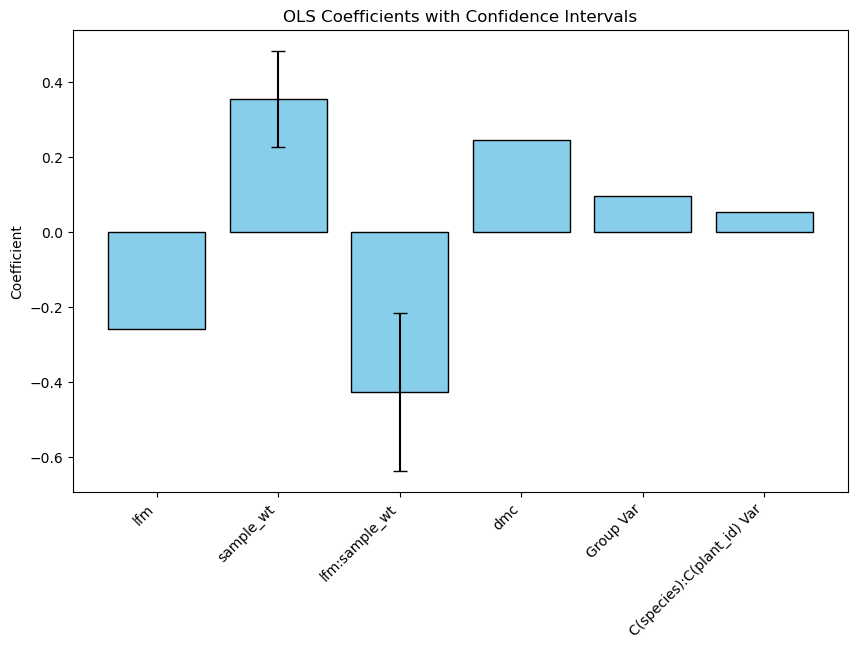

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5570   
Min. group size:        8           Log-Likelihood:         -186.7362
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.107    0.188 -0.570 0.569 -0.475  0.261
sample_wt                   0.487    0.116  4.183 0.000  0.259  0.715
dmc                         0.419    0.134  3.135 0.002  0.157  0.681
sample_wt:dmc               0.137    0.108  1.278 0.201 -0.073  0.348
lfm                        -0.205   

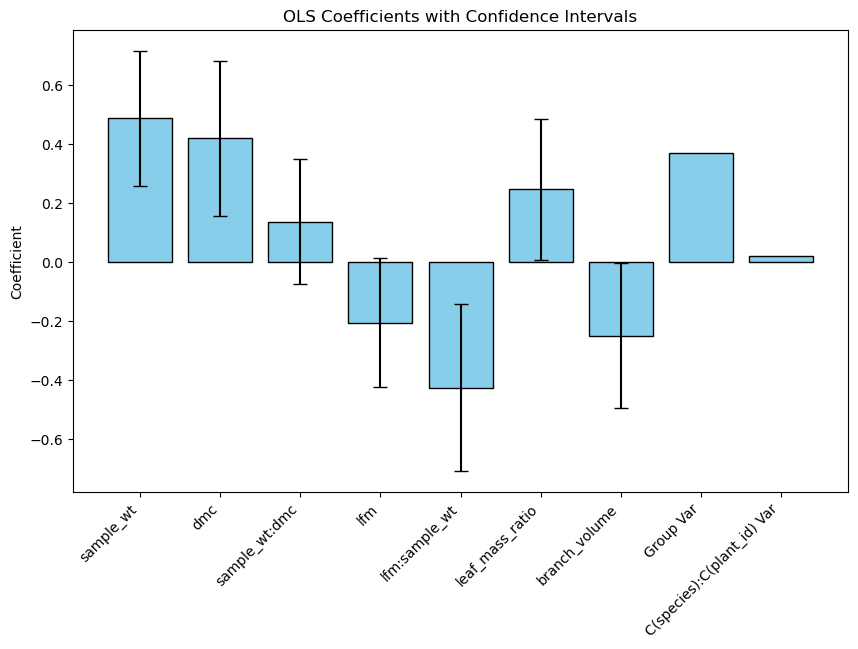

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5553   
Min. group size:        8           Log-Likelihood:         -186.7754
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.087    0.194 -0.450 0.653 -0.468  0.293
lfm                        -0.261    0.117 -2.230 0.026 -0.491 -0.032
sample_wt                   0.494    0.115  4.296 0.000  0.268  0.719
lfm:sample_wt              -0.552    0.115 -4.796 0.000 -0.778 -0.327
leaf_mass_ratio             0.269   

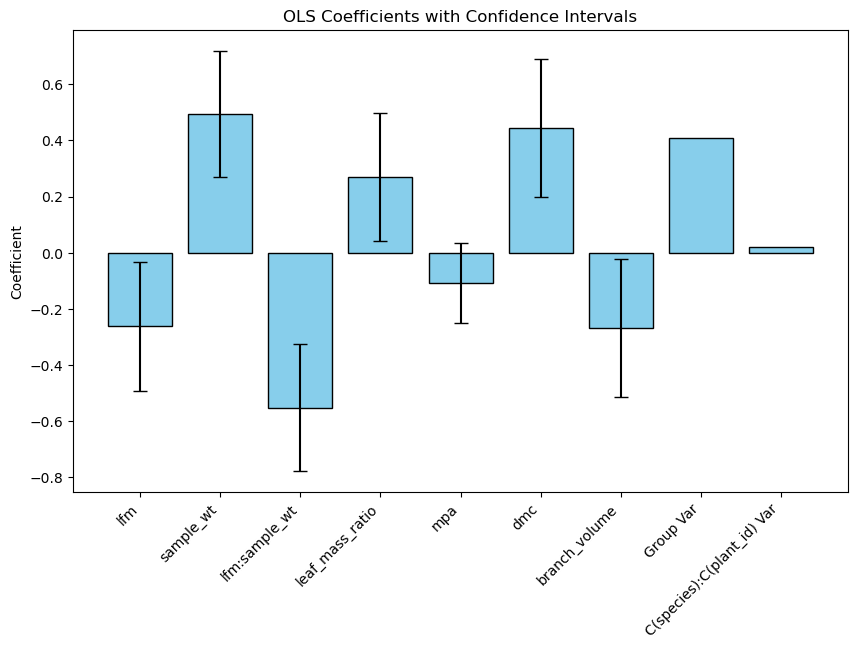

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5709   
Min. group size:        8           Log-Likelihood:         -187.7909
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.112    0.132 -0.847 0.397 -0.372  0.147
sample_wt                   0.467    0.054  8.692 0.000  0.362  0.572
dmc                         0.238    0.066  3.593 0.000  0.108  0.368
sample_wt:dmc               0.106    0.012  9.178 0.000  0.083  0.129
lfm                        -0.296   

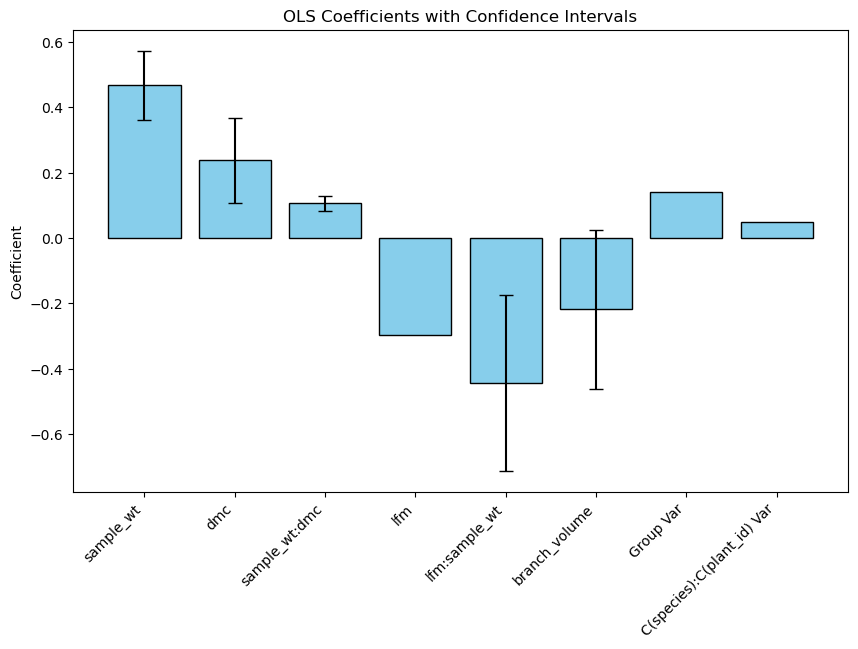

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5722   
Min. group size:        8           Log-Likelihood:         -187.9255
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.096    0.131 -0.732 0.464 -0.354  0.161
lfm                        -0.335                                    
sample_wt                   0.473                                    
lfm:sample_wt              -0.536    0.080 -6.695 0.000 -0.693 -0.379
mpa                        -0.062   

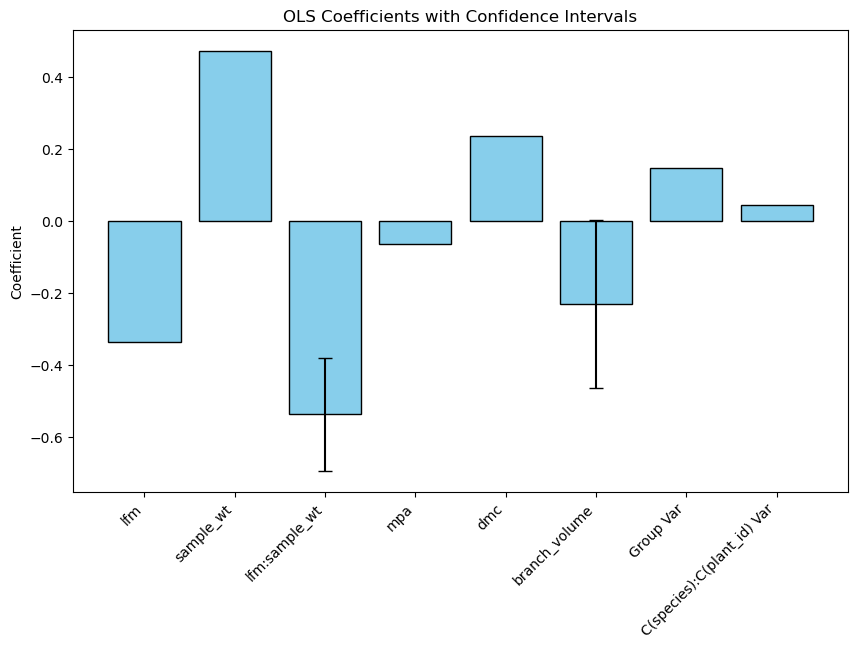

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5858   
Min. group size:        8           Log-Likelihood:         -187.9256
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.099    0.081 -1.218 0.223 -0.258  0.060
lfm                        -0.420    0.115 -3.641 0.000 -0.646 -0.194
sample_wt                   0.513    0.117  4.400 0.000  0.285  0.742
lfm:sample_wt              -0.528    0.104 -5.099 0.000 -0.732 -0.325
dmc                         0.176   

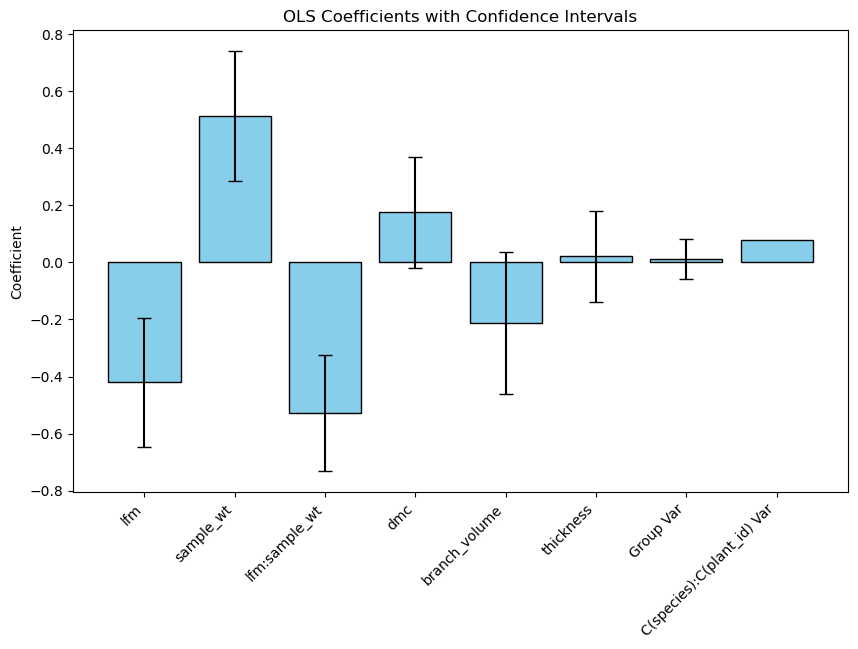

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5768   
Min. group size:        8           Log-Likelihood:         -187.9430
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.093    0.116 -0.805 0.421 -0.320  0.133
lfm                        -0.345    0.249 -1.384 0.166 -0.833  0.143
sample_wt                   0.495    0.137  3.623 0.000  0.227  0.763
lfm:sample_wt              -0.521    0.148 -3.513 0.000 -0.811 -0.230
branching                  -0.010   

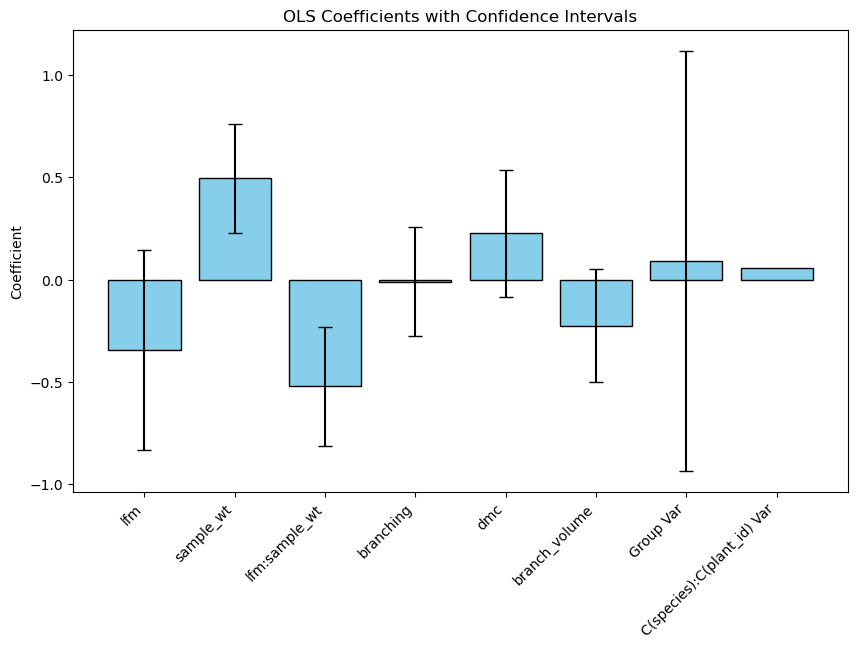

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5804   
Min. group size:        8           Log-Likelihood:         -187.9753
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.101    0.083 -1.212 0.226 -0.263  0.062
lfm                        -0.427    0.118 -3.610 0.000 -0.659 -0.195
sample_wt                   0.495    0.119  4.161 0.000  0.262  0.728
lfm:sample_wt              -0.537    0.099 -5.432 0.000 -0.731 -0.343
dmc                         0.168   

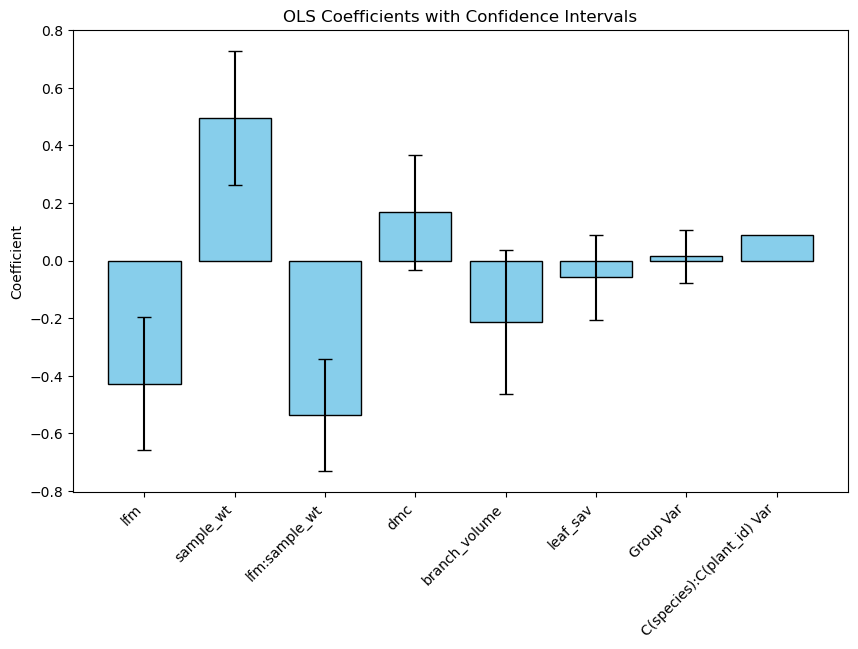

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fd       
No. Observations:      158          Method:                  ML       
No. Groups:            7            Scale:                   0.6007   
Min. group size:       8            Log-Likelihood:          -189.0440
Max. group size:       37           Converged:               Yes      
Mean group size:       22.6                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  -0.106    0.089  -1.191 0.234 -0.280  0.068
lfm                        -0.497    0.040 -12.427 0.000 -0.575 -0.418
sample_wt                   0.526    0.117   4.505 0.000  0.297  0.755
lfm:sample_wt              -0.536    0.152  -3.515 0.000 -0.834 -0.237
branch_volume          

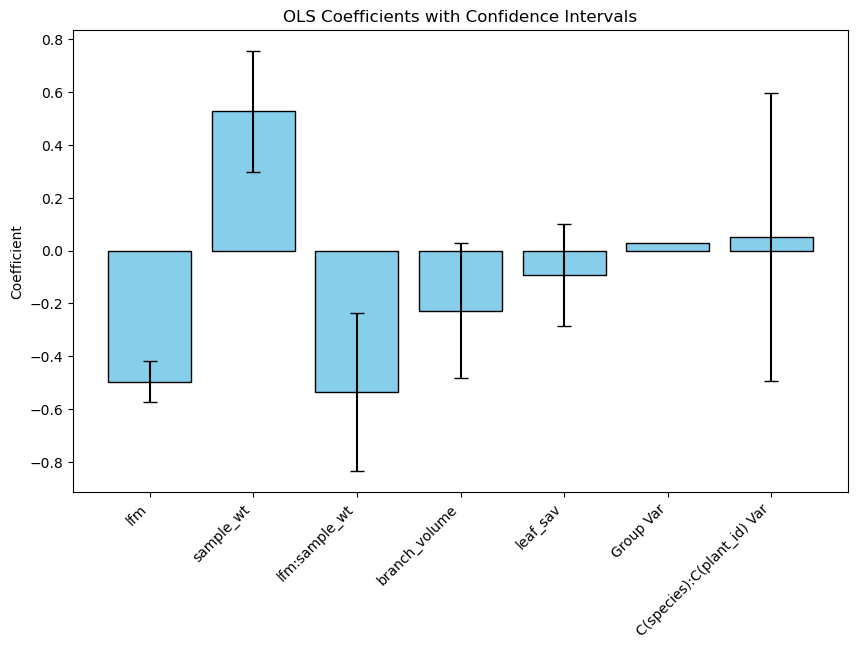

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5495   
Min. group size:        8           Log-Likelihood:         -186.1138
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.117    0.217 -0.541 0.588 -0.542  0.308
sample_wt                   0.465    0.115  4.033 0.000  0.239  0.691
dmc                         0.453    0.133  3.404 0.001  0.192  0.713
sample_wt:dmc               0.139    0.108  1.288 0.198 -0.072  0.350
lfm                        -0.227   

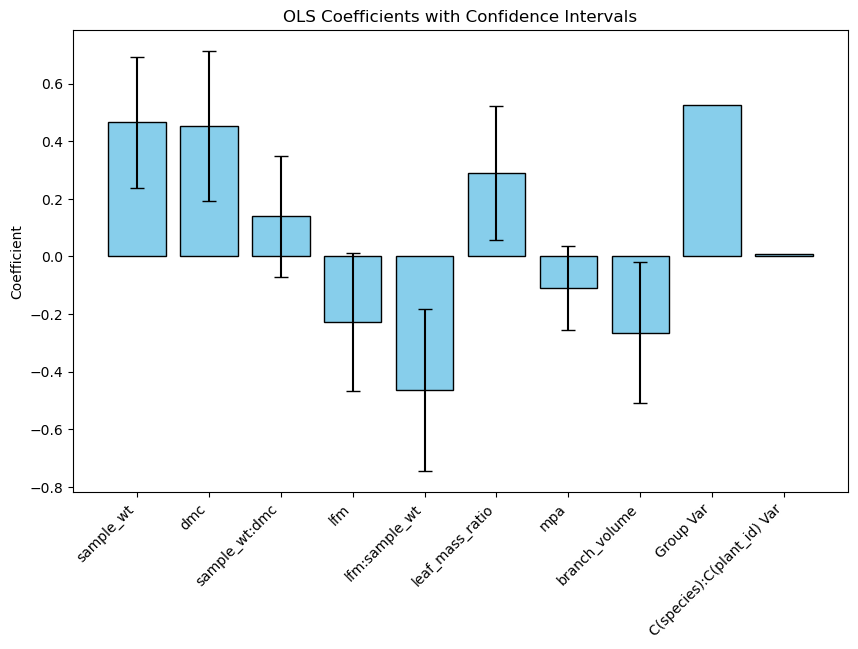

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5772   
Min. group size:        8           Log-Likelihood:         -189.1223
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.047    0.156 -0.299 0.765 -0.352  0.259
lfm                        -0.172    0.090 -1.902 0.057 -0.349  0.005
sample_wt                   0.368    0.089  4.125 0.000  0.193  0.543
lfm:sample_wt              -0.413    0.111 -3.704 0.000 -0.631 -0.194
leaf_mass_ratio             0.186   

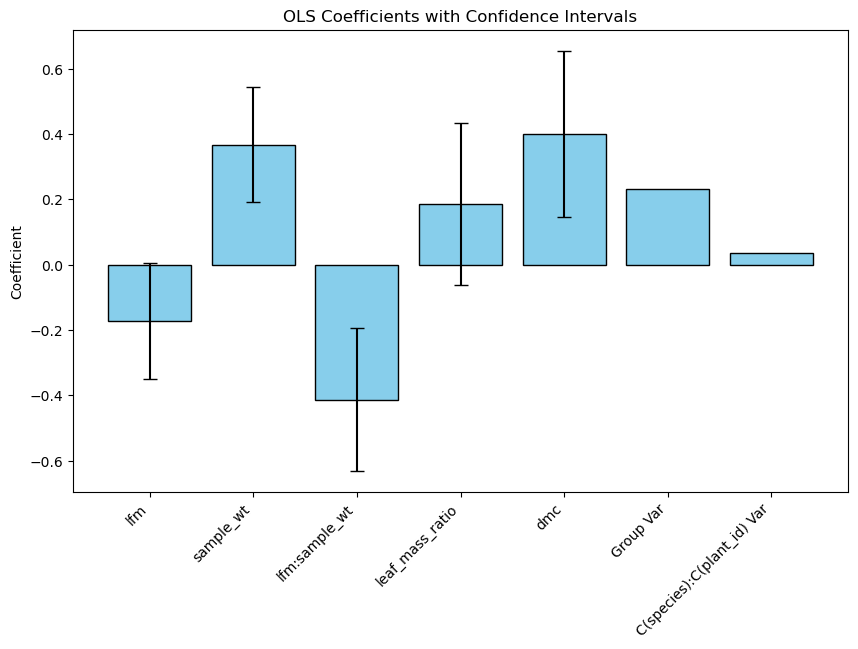

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5621   
Min. group size:        8           Log-Likelihood:         -187.1486
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.082    0.156 -0.525 0.599 -0.389  0.224
lfm                        -0.263    0.102 -2.585 0.010 -0.462 -0.064
sample_wt                   0.513    0.119  4.319 0.000  0.280  0.746
lfm:sample_wt              -0.509    0.116 -4.403 0.000 -0.735 -0.282
leaf_mass_ratio             0.228   

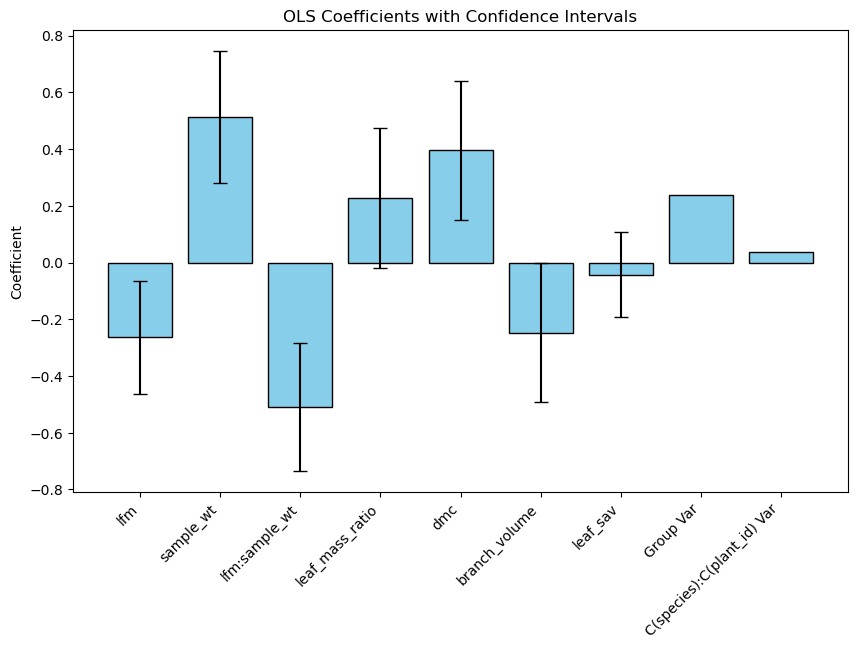

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5796   
Min. group size:        8           Log-Likelihood:         -188.1535
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.104    0.086 -1.212 0.226 -0.271  0.064
lfm                        -0.407    0.150 -2.714 0.007 -0.701 -0.113
sample_wt                   0.520    0.123  4.239 0.000  0.280  0.761
lfm:sample_wt              -0.533    0.113 -4.739 0.000 -0.754 -0.313
start_temp                  0.044   

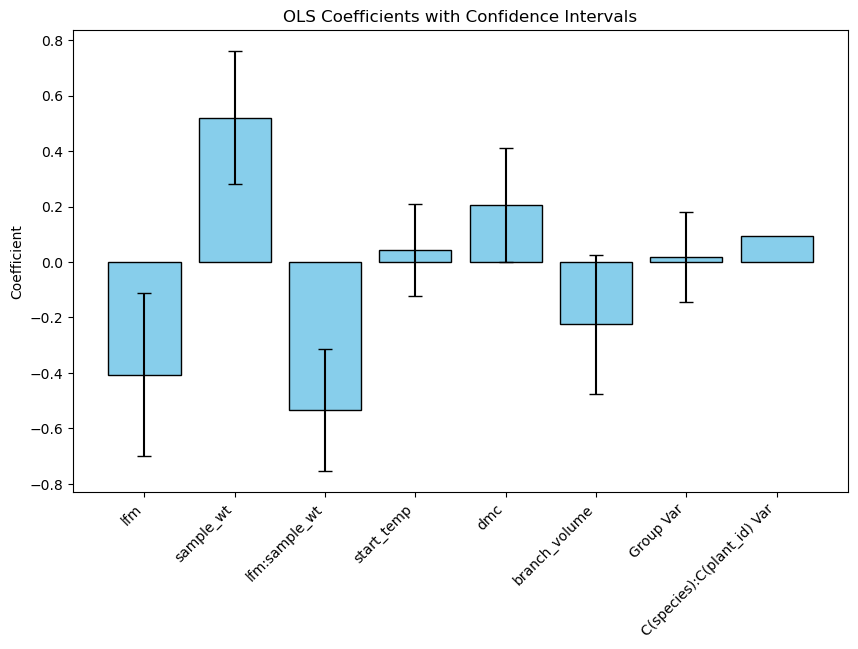

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5764   
Min. group size:        8           Log-Likelihood:         -188.1849
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.100    0.090 -1.108 0.268 -0.278  0.077
lfm                        -0.390                                    
sample_wt                   0.485    0.114  4.258 0.000  0.262  0.709
lfm:sample_wt              -0.530    0.108 -4.894 0.000 -0.743 -0.318
LMA                         0.062   

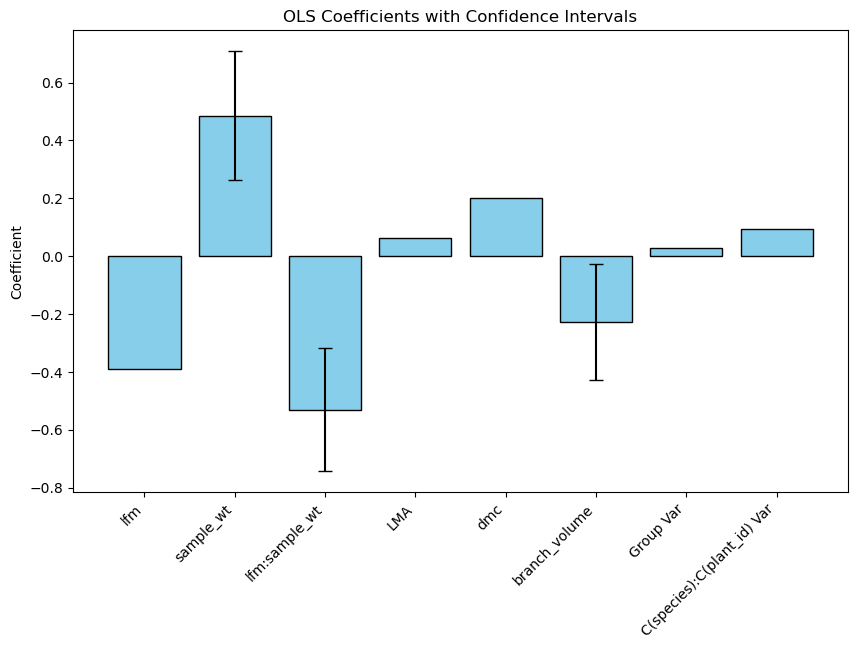

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5627   
Min. group size:        8           Log-Likelihood:         -187.1849
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.081    0.160 -0.504 0.614 -0.395  0.233
lfm                        -0.247    0.096 -2.576 0.010 -0.436 -0.059
sample_wt                   0.517    0.116  4.453 0.000  0.290  0.745
lfm:sample_wt              -0.512    0.114 -4.471 0.000 -0.736 -0.287
leaf_mass_ratio             0.224   

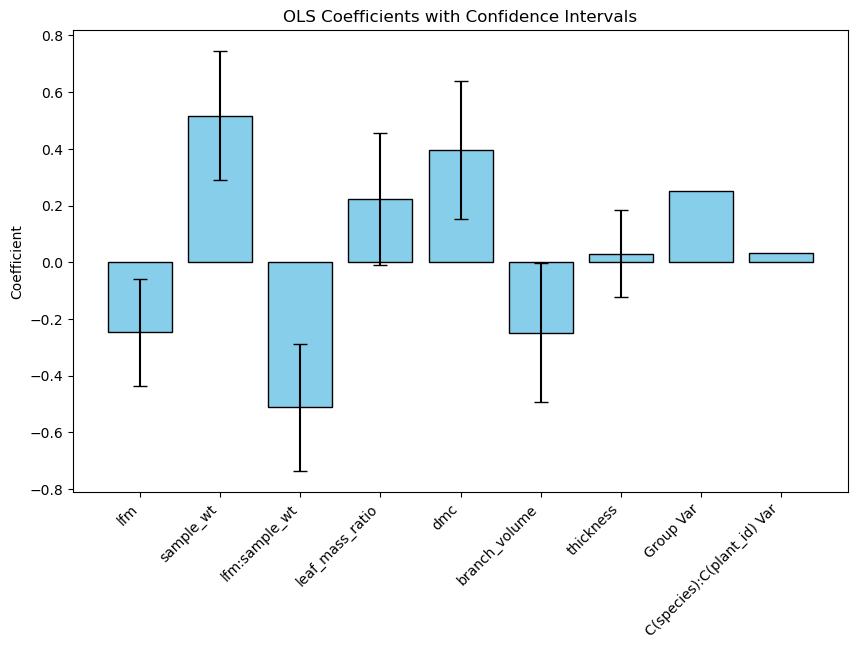

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5971   
Min. group size:        8           Log-Likelihood:         -189.1946
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.073    0.081 -0.899 0.368 -0.231  0.086
lfm                        -0.351    0.122 -2.874 0.004 -0.590 -0.112
sample_wt                   0.371    0.080  4.637 0.000  0.214  0.527
lfm:sample_wt              -0.443    0.100 -4.447 0.000 -0.639 -0.248
dmc                         0.186   

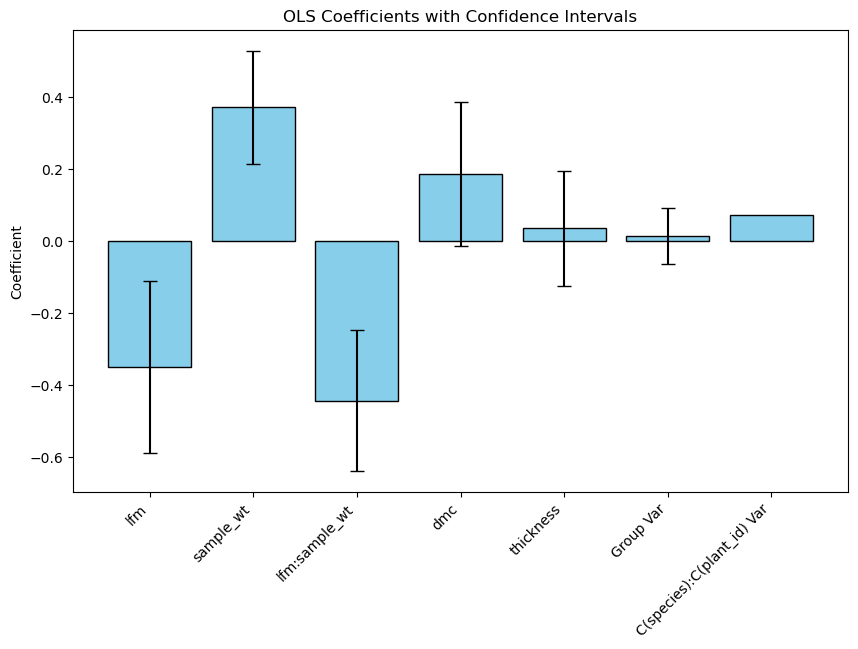

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.5612   
Min. group size:        8           Log-Likelihood:         -187.2105
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.094    0.150 -0.628 0.530 -0.389  0.200
lfm                        -0.264    0.116 -2.269 0.023 -0.491 -0.036
sample_wt                   0.509    0.122  4.174 0.000  0.270  0.748
lfm:sample_wt              -0.526    0.120 -4.405 0.000 -0.761 -0.292
leaf_mass_ratio             0.237   

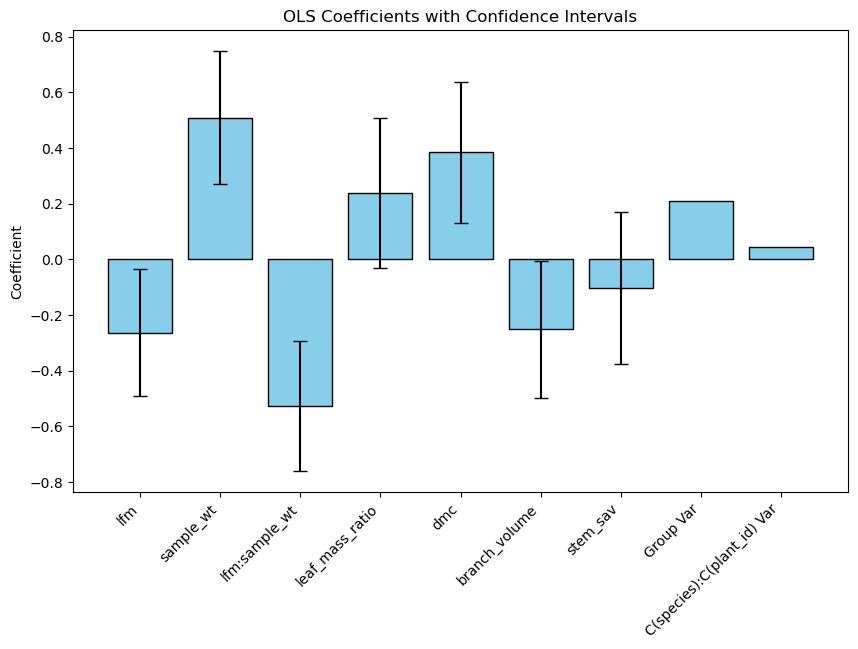

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fd       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.6029   
Min. group size:        8           Log-Likelihood:         -189.2112
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.105    0.090 -1.175 0.240 -0.281  0.070
lfm                        -0.464                                    
sample_wt                   0.545    0.064  8.534 0.000  0.419  0.670
lfm:sample_wt              -0.529    0.136 -3.883 0.000 -0.796 -0.262
branch_volume              -0.229   

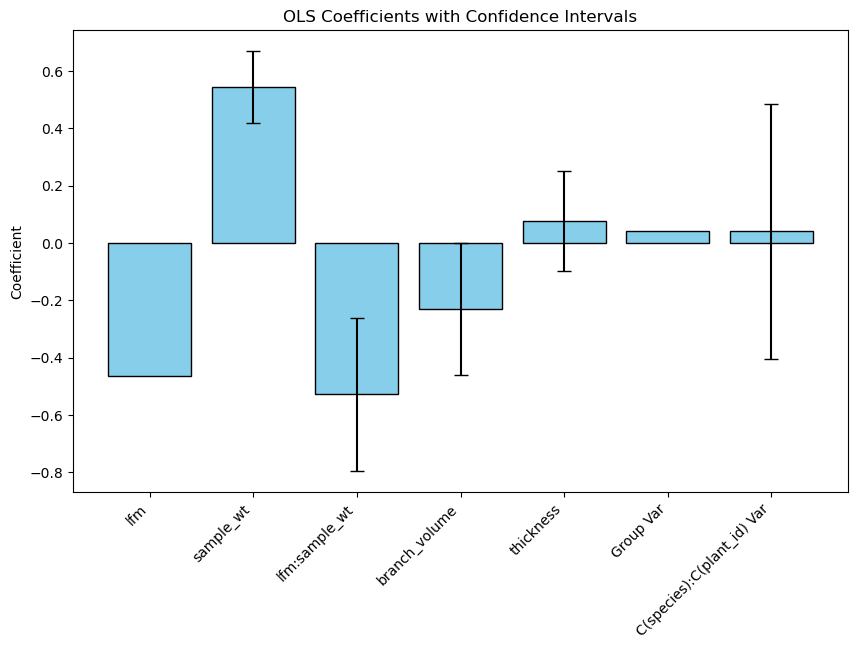

In [11]:
AIC_iterator(flam, cols_use, Y_VAR='fd',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Temp Change

In [12]:
yvar='temp_change'
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0               LMA  401.455324  0.146477  3.628360e-01     True
1     branch_volume  400.626960  0.115343  2.132302e-01     True
2               dmc  397.858765  0.229424  2.942629e-02    False
3               lfm  396.316699 -0.330708  1.533037e-02    False
4          leaf_sav  396.311562 -0.298959  1.317164e-02    False
5         thickness  395.855289  0.268303  9.864805e-03    False
6               mpa  395.786266  0.227803  1.088857e-02    False
7          stem_sav  395.612568 -0.369712  7.787386e-03    False
8   leaf_mass_ratio  394.783638 -0.334845           NaN    False
9         sample_wt  394.549162  0.274254  4.605771e-03    False
10        branching  388.874141  0.278646  2.061610e-04    False
11       start_temp  367.827414 -0.493711  1.473413e-10    False



Columns present in sig. interaction terms: {'start_temp', 'lfm'}

Total Num. Cols : Num. Sig. Int. Cols;  12 : 2

Significant Interactions:
('lfm', 'start_temp')

Number of formulas: 5121
ERROR: Formula model error: temp_change ~ 


temp_change ~ lfm*start_temp + sample_wt + branching + mpa
temp_change ~ lfm*start_temp + sample_wt + branching
temp_change ~ lfm*start_temp + LMA + sample_wt + branching + mpa
temp_change ~ lfm*start_temp + branching
temp_change ~ lfm*start_temp + sample_wt + branching + mpa + stem_sav
temp_change ~ lfm*start_temp + branching + mpa
temp_change ~ lfm*start_temp + sample_wt + branching + stem_sav
temp_change ~ lfm*start_temp + sample_wt + branching + mpa + dmc
temp_change ~ lfm*start_temp + sample_wt + branching + mpa + leaf_sav
temp_change ~ lfm*start_temp + sample_wt + branching + mpa + branch_volume
temp_change ~ lfm*start_temp + sample_wt + leaf_mass_ratio + branching + mpa
temp_change ~ lfm*start_temp + sample_wt + branching + mpa + thickness


       

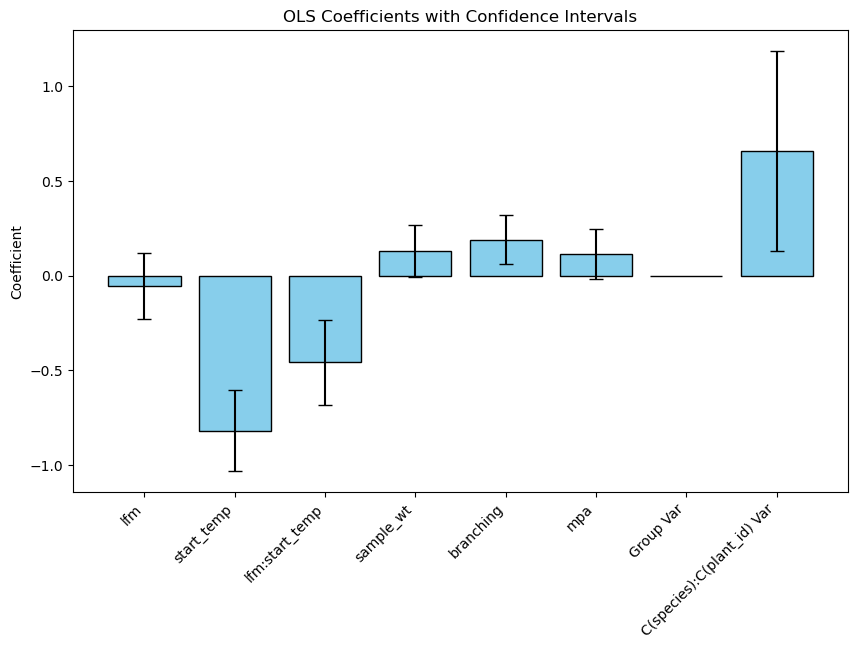

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3212     
Min. group size:      8           Log-Likelihood:         -158.9805  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.087    0.081  1.067 0.286 -0.073  0.246
lfm                        -0.075    0.087 -0.855 0.393 -0.245  0.096
start_temp                 -0.811    0.109 -7.416 0.000 -1.025 -0.597
lfm:start_temp             -0.445    0.116 -3.846 0.000 -0.672 -0.218
sample_wt                   0.108   

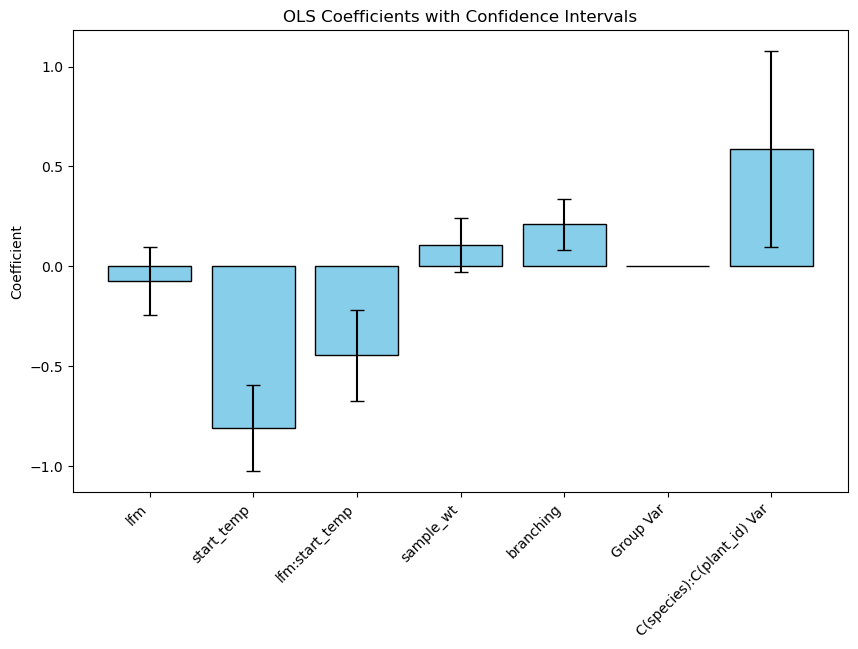

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3117     
Min. group size:      8           Log-Likelihood:         -157.1915  
Max. group size:      37          Converged:              No         
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.093    0.081  1.139 0.255 -0.067  0.252
lfm                        -0.065    0.089 -0.730 0.465 -0.239  0.109
start_temp                 -0.822    0.108 -7.617 0.000 -1.033 -0.610
lfm:start_temp             -0.454    0.114 -3.999 0.000 -0.677 -0.232
LMA                        -0.086   

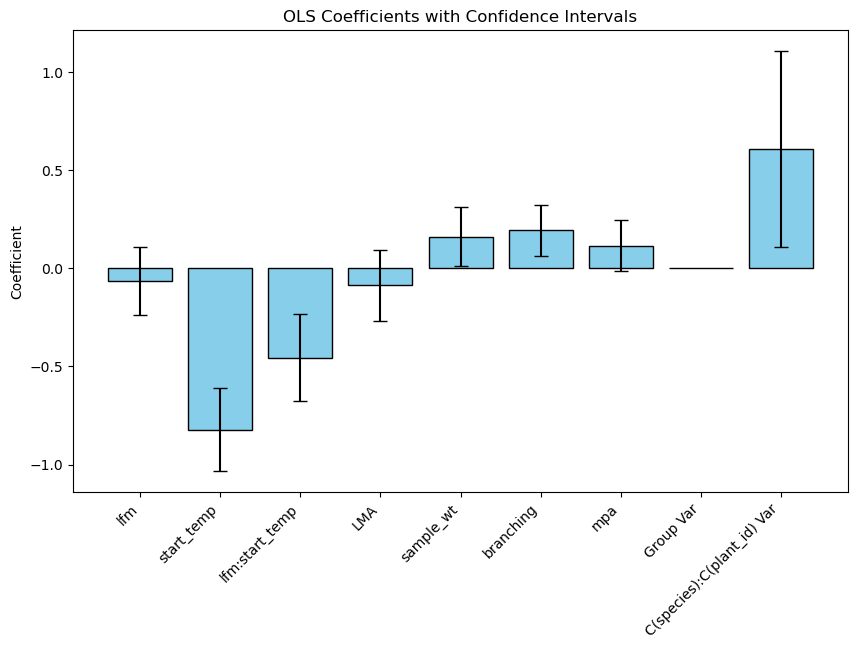

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3150     
Min. group size:      8           Log-Likelihood:         -160.1988  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.099    0.085  1.169 0.242 -0.067  0.265
lfm                        -0.085    0.089 -0.954 0.340 -0.260  0.090
start_temp                 -0.861    0.106 -8.115 0.000 -1.069 -0.653
lfm:start_temp             -0.488    0.115 -4.242 0.000 -0.713 -0.262
branching                   0.226   

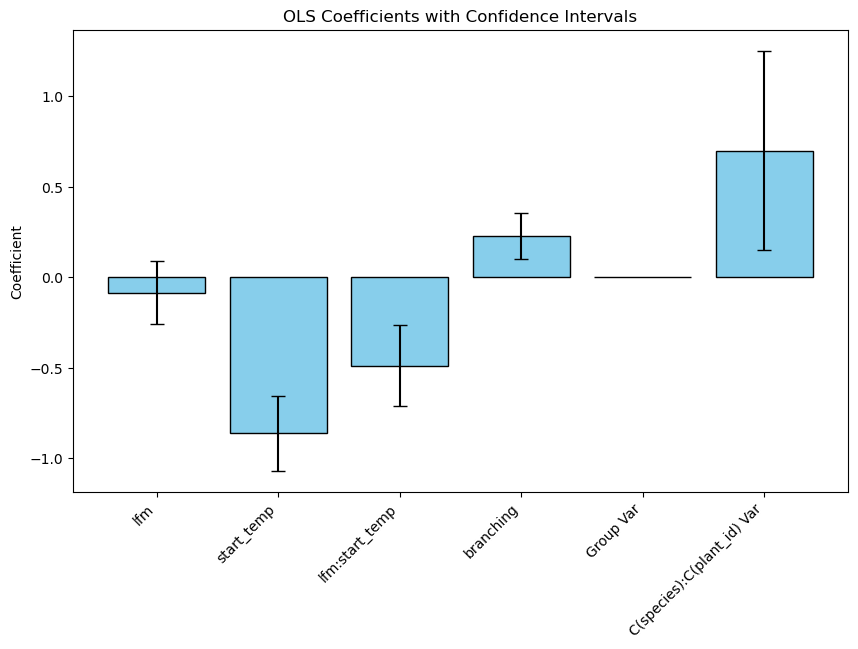

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3071     
Min. group size:      8           Log-Likelihood:         -157.2171  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.103    0.083  1.238 0.216 -0.060  0.266
lfm                        -0.102    0.105 -0.968 0.333 -0.309  0.105
start_temp                 -0.856    0.117 -7.311 0.000 -1.086 -0.627
lfm:start_temp             -0.492    0.121 -4.074 0.000 -0.729 -0.255
sample_wt                   0.149   

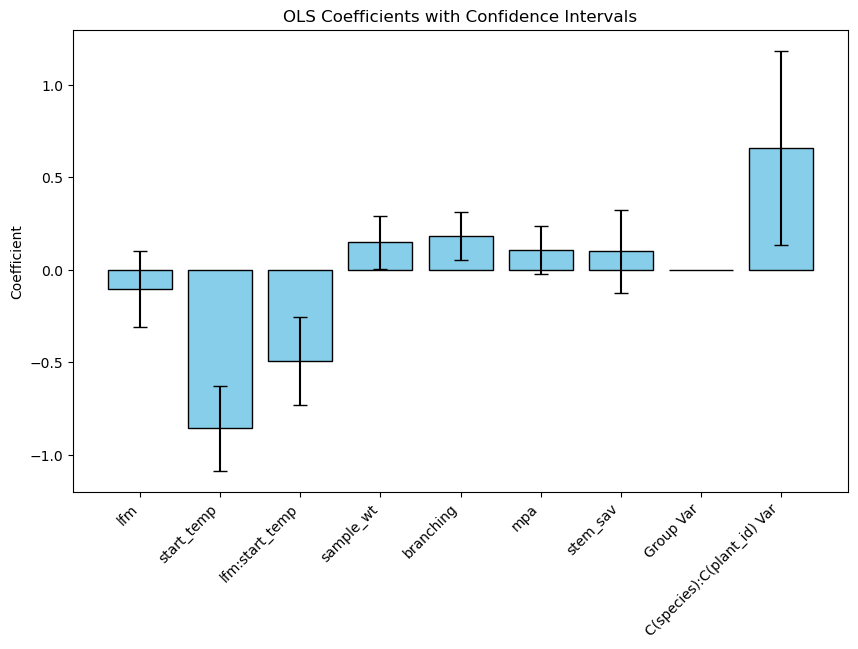

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3051     
Min. group size:      8           Log-Likelihood:         -159.2553  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.106    0.086  1.241 0.215 -0.062  0.274
lfm                        -0.071    0.091 -0.775 0.439 -0.249  0.108
start_temp                 -0.872    0.102 -8.542 0.000 -1.072 -0.672
lfm:start_temp             -0.500    0.113 -4.443 0.000 -0.721 -0.280
branching                   0.213   

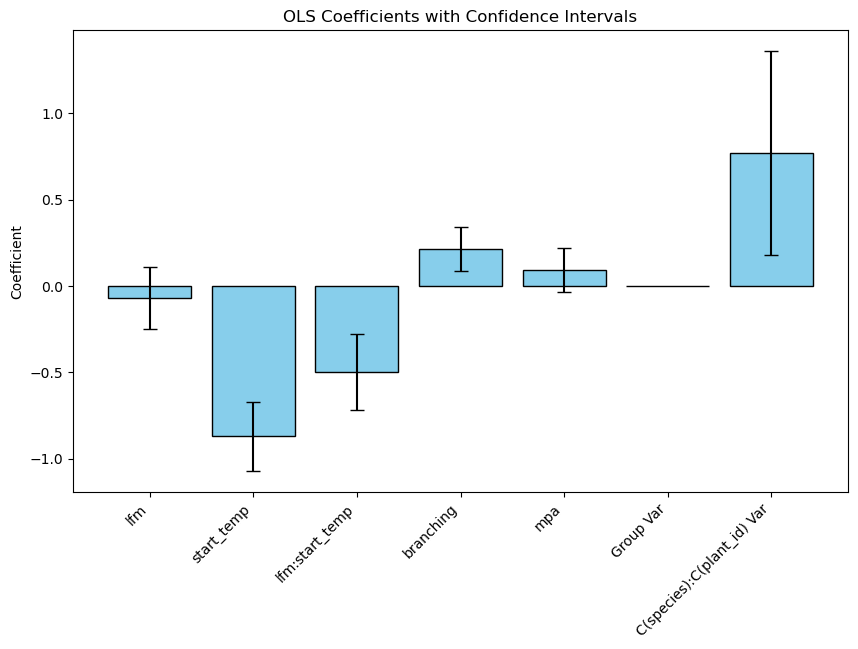

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3183     
Min. group size:      8           Log-Likelihood:         -158.4505  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.098    0.082  1.196 0.232 -0.063  0.259
lfm                        -0.130    0.103 -1.261 0.207 -0.331  0.072
start_temp                 -0.856    0.119 -7.208 0.000 -1.089 -0.623
lfm:start_temp             -0.487    0.123 -3.951 0.000 -0.728 -0.245
sample_wt                   0.135   

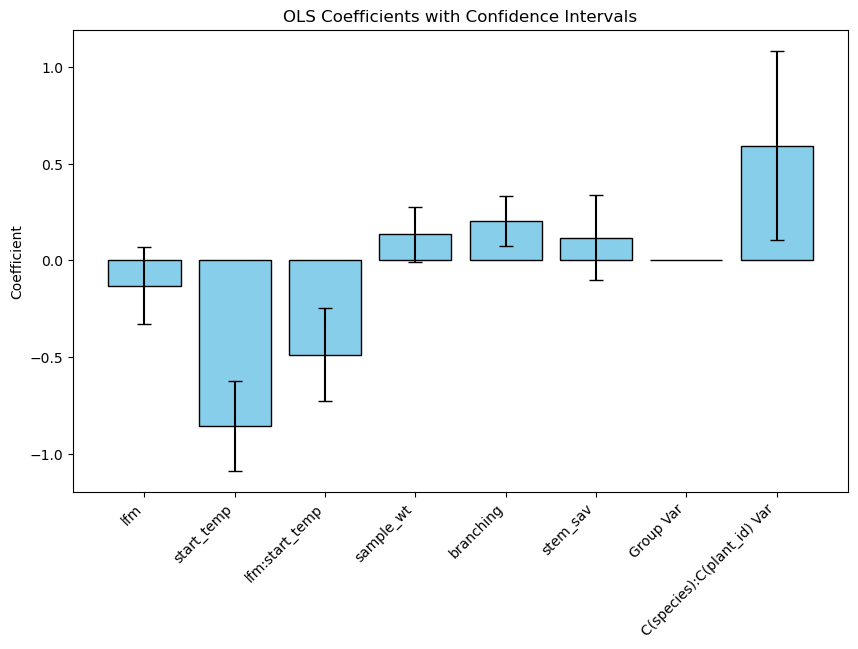

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3081     
Min. group size:      8           Log-Likelihood:         -157.4628  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.094    0.083  1.144 0.253 -0.067  0.256
lfm                        -0.078    0.101 -0.780 0.435 -0.275  0.119
start_temp                 -0.830    0.111 -7.485 0.000 -1.048 -0.613
lfm:start_temp             -0.456    0.114 -4.004 0.000 -0.680 -0.233
sample_wt                   0.134   

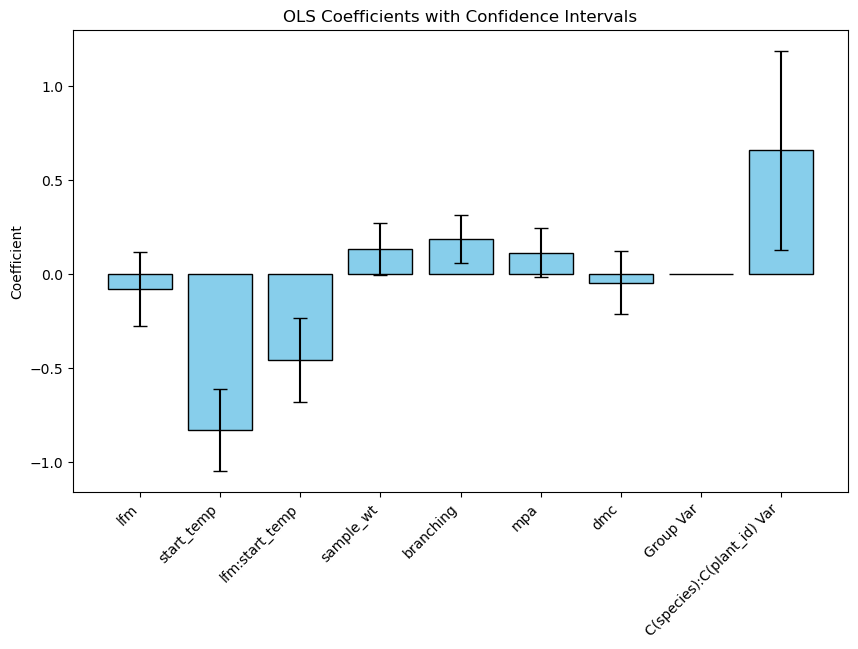

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3091     
Min. group size:      8           Log-Likelihood:         -157.5208  
Max. group size:      37          Converged:              No         
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.093    0.082  1.127 0.260 -0.069  0.254
lfm                        -0.052    0.089 -0.591 0.555 -0.227  0.122
start_temp                 -0.809    0.111 -7.287 0.000 -1.027 -0.592
lfm:start_temp             -0.457    0.114 -4.025 0.000 -0.680 -0.235
sample_wt                   0.122   

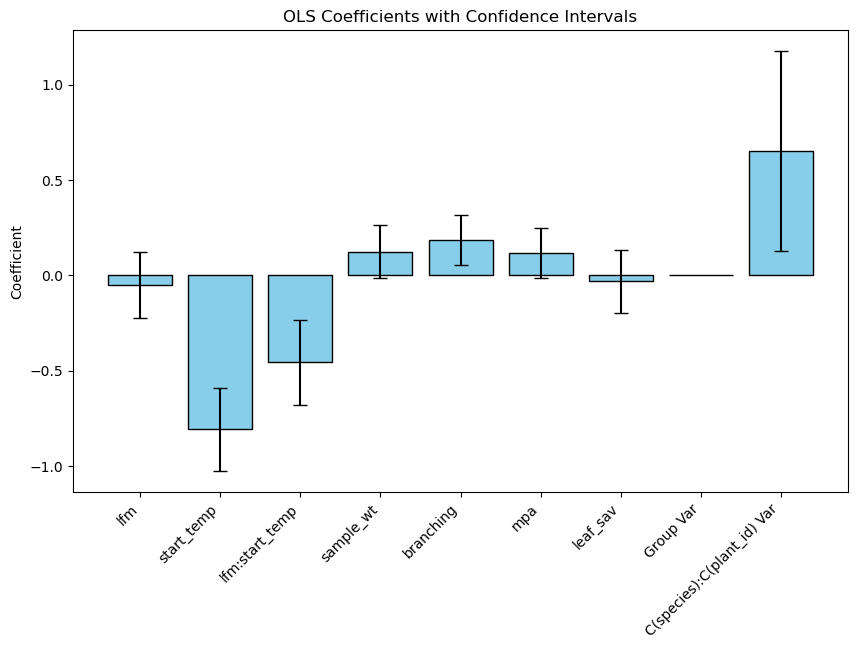

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3082     
Min. group size:      8           Log-Likelihood:         -157.5420  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.092    0.083  1.115 0.265 -0.070  0.254
lfm                        -0.057    0.090 -0.639 0.523 -0.233  0.118
start_temp                 -0.815    0.109 -7.457 0.000 -1.029 -0.600
lfm:start_temp             -0.454    0.115 -3.967 0.000 -0.679 -0.230
sample_wt                   0.150   

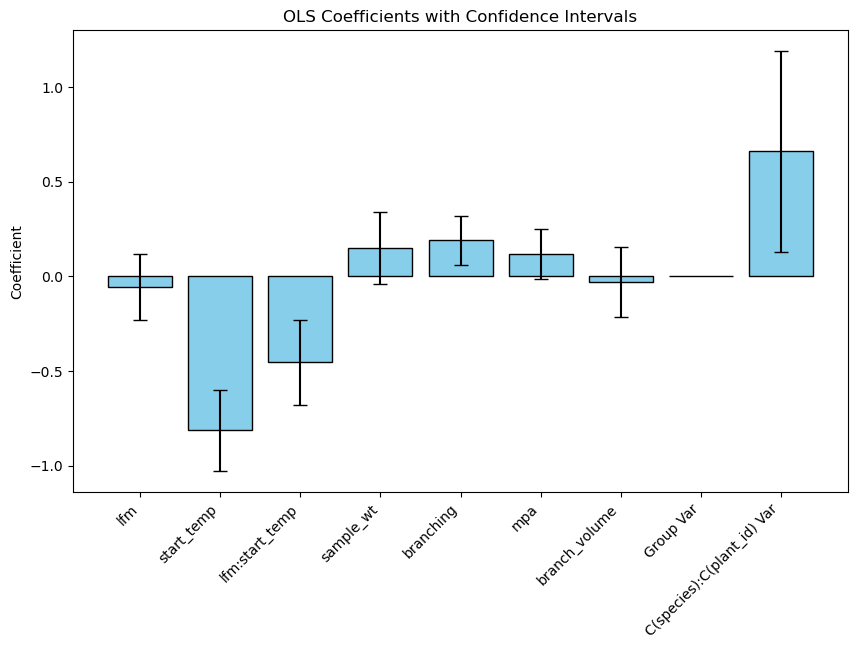

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3080     
Min. group size:      8           Log-Likelihood:         -157.5828  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.095    0.083  1.140 0.254 -0.068  0.257
lfm                        -0.057    0.092 -0.623 0.534 -0.238  0.123
start_temp                 -0.825    0.115 -7.146 0.000 -1.051 -0.599
lfm:start_temp             -0.462    0.116 -3.978 0.000 -0.689 -0.234
sample_wt                   0.132   

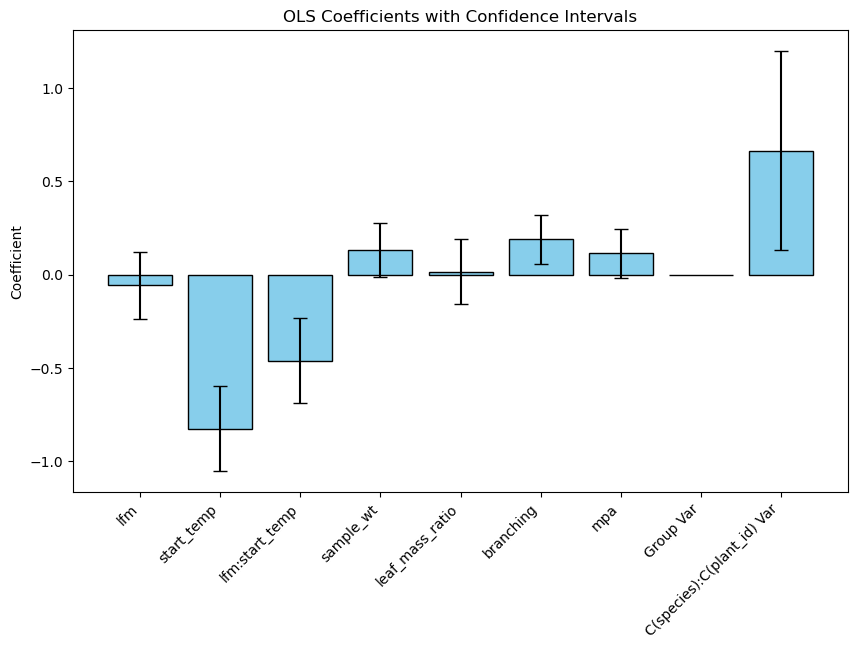

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     temp_change
No. Observations:     158         Method:                 ML         
No. Groups:           7           Scale:                  0.3087     
Min. group size:      8           Log-Likelihood:         -157.5866  
Max. group size:      37          Converged:              Yes        
Mean group size:      22.6                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.094    0.083  1.136 0.256 -0.068  0.256
lfm                        -0.051    0.091 -0.567 0.571 -0.229  0.126
start_temp                 -0.815    0.111 -7.333 0.000 -1.033 -0.597
lfm:start_temp             -0.460    0.114 -4.014 0.000 -0.684 -0.235
sample_wt                   0.128   

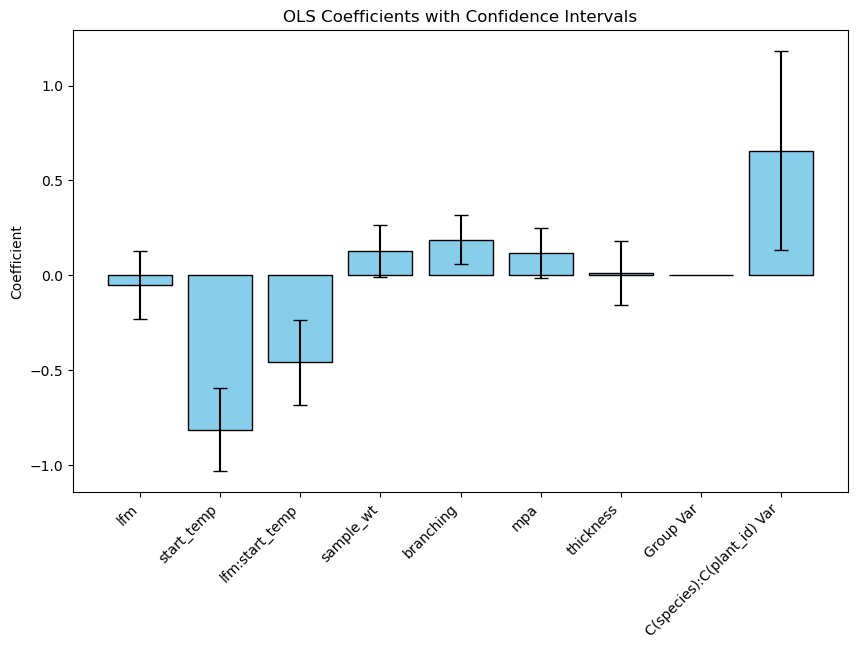

In [13]:
AIC_iterator(flam, cols_use, Y_VAR='temp_change',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Heat Flux Change

In [14]:
yvar='heat_flux_change'
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0               mpa  411.826041 -0.046794  6.066879e-01     True
1         thickness  411.597043  0.081887  4.818602e-01     True
2               dmc  410.370768  0.142433  1.813702e-01     True
3        start_temp  409.489495  0.152893  1.064645e-01    False
4               lfm  407.509224 -0.302763  3.131805e-02    False
5          leaf_sav  407.063694 -0.289654  3.109377e-02    False
6   leaf_mass_ratio  406.447131 -0.288720  9.929759e-03    False
7          stem_sav  405.623189 -0.354519  1.509678e-03    False
8         branching  404.072725  0.223362  3.867067e-03    False
9               LMA  391.352558  0.534987  6.245420e-07    False
10    branch_volume  391.130515  0.396857  1.602737e-06    False
11        sample_wt  331.797298  0.728534  1.295792e-20    False


ERROR: Formula model error: heat_flux_change ~ leaf_sav*thickness

Columns present in sig. interaction terms: {'sample_wt', 'start_temp'}

Total Num. Cols : Num. Sig. Int. Cols;  12 : 2

Significant Interactions:
('sample_wt', 'start_temp')

Number of formulas: 5121
ERROR: Formula model error: heat_flux_change ~ 


heat_flux_change ~ sample_wt*start_temp + LMA
heat_flux_change ~ sample_wt*start_temp + LMA + thickness
heat_flux_change ~ sample_wt*start_temp + LMA + stem_sav
heat_flux_change ~ sample_wt*start_temp + LMA + leaf_sav
heat_flux_change ~ sample_wt*start_temp + LMA + branching
heat_flux_change ~ sample_wt*start_temp + lfm + LMA
heat_flux_change ~ sample_wt*start_temp + LMA + mpa
heat_flux_change ~ sample_wt*start_temp + LMA + dmc
heat_flux_change ~ sample_wt*start_temp
heat_flux_change ~ sample_wt*start_temp
heat_flux_change ~ sample_wt*start_temp + LMA + branch_volume
heat_flux_change ~ sample_wt*start_temp + LMA + leaf_mass_ratio


                Mixed Linear Model Regressi

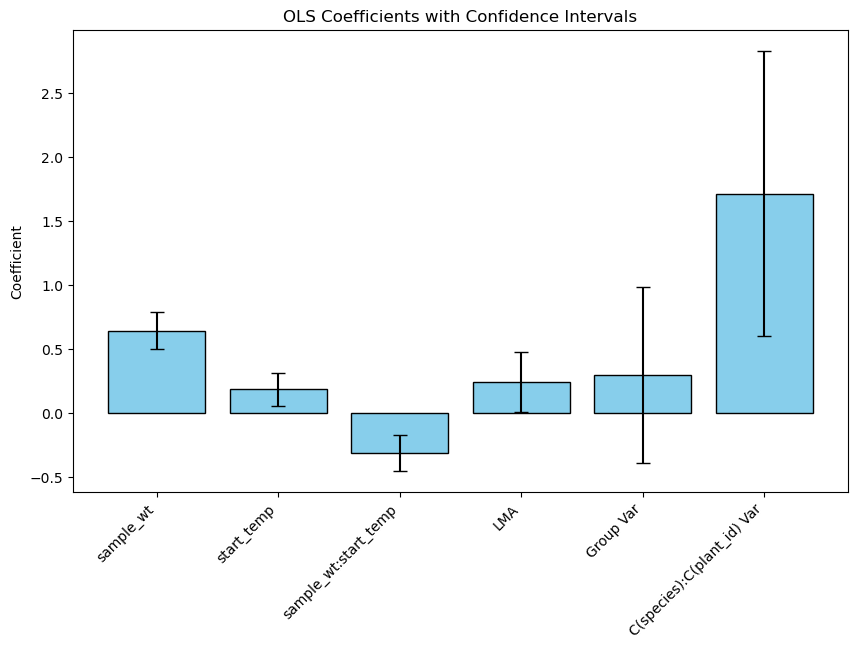

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2075          
Min. group size:     8         Log-Likelihood:       -145.8804       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.095    0.131 -0.728 0.467 -0.351  0.161
sample_wt                   0.639    0.074  8.685 0.000  0.495  0.784
start_temp                  0.208    0.072  2.880 0.004  0.066  0.349
sample_wt:start_temp       -0.310    0.071 -4.344 0.000 -0.450 -0.170
LMA                         0.217   

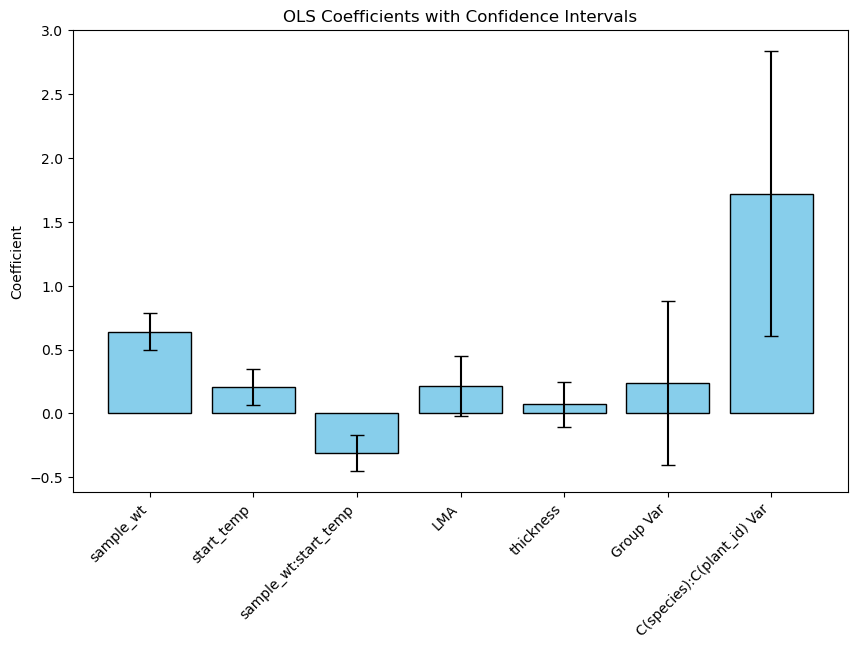

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2070          
Min. group size:     8         Log-Likelihood:       -145.9058       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.083    0.139 -0.597 0.551 -0.354  0.189
sample_wt                   0.649    0.073  8.910 0.000  0.506  0.791
start_temp                  0.180    0.067  2.688 0.007  0.049  0.312
sample_wt:start_temp       -0.312    0.071 -4.370 0.000 -0.452 -0.172
LMA                         0.283   

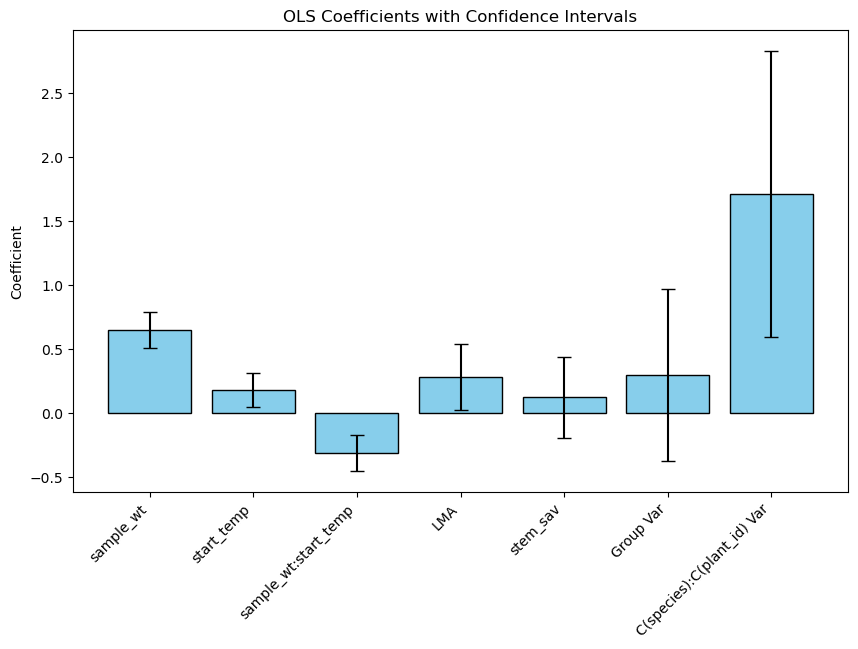

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2077          
Min. group size:     8         Log-Likelihood:       -145.9443       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.095    0.135 -0.708 0.479 -0.360  0.169
sample_wt                   0.640    0.074  8.703 0.000  0.496  0.784
start_temp                  0.200    0.070  2.866 0.004  0.063  0.337
sample_wt:start_temp       -0.311    0.071 -4.354 0.000 -0.451 -0.171
LMA                         0.207   

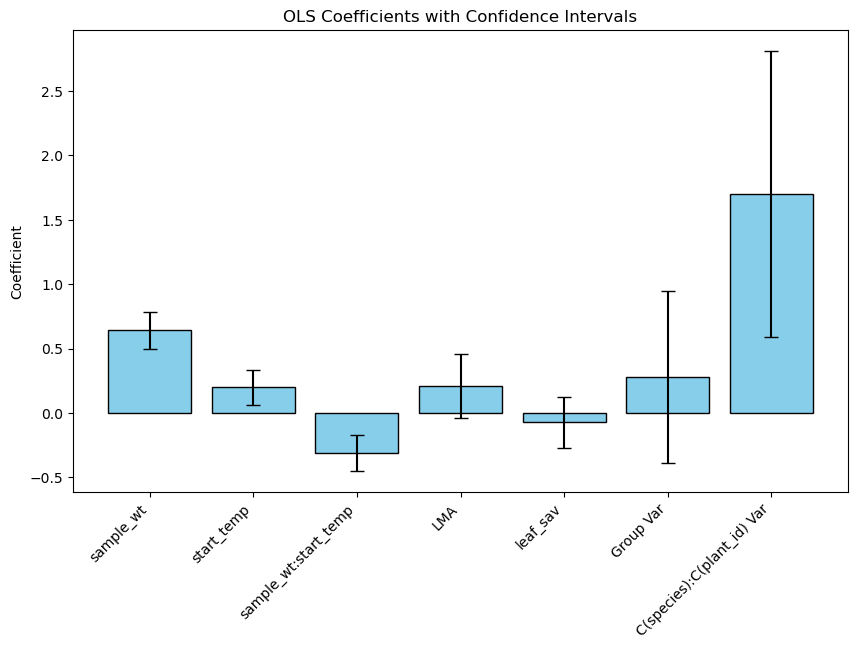

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2077          
Min. group size:     8         Log-Likelihood:       -145.9506       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.096    0.130 -0.738 0.461 -0.351  0.159
sample_wt                   0.629    0.076  8.280 0.000  0.480  0.778
start_temp                  0.189    0.067  2.838 0.005  0.058  0.319
sample_wt:start_temp       -0.306    0.072 -4.247 0.000 -0.447 -0.165
LMA                         0.229   

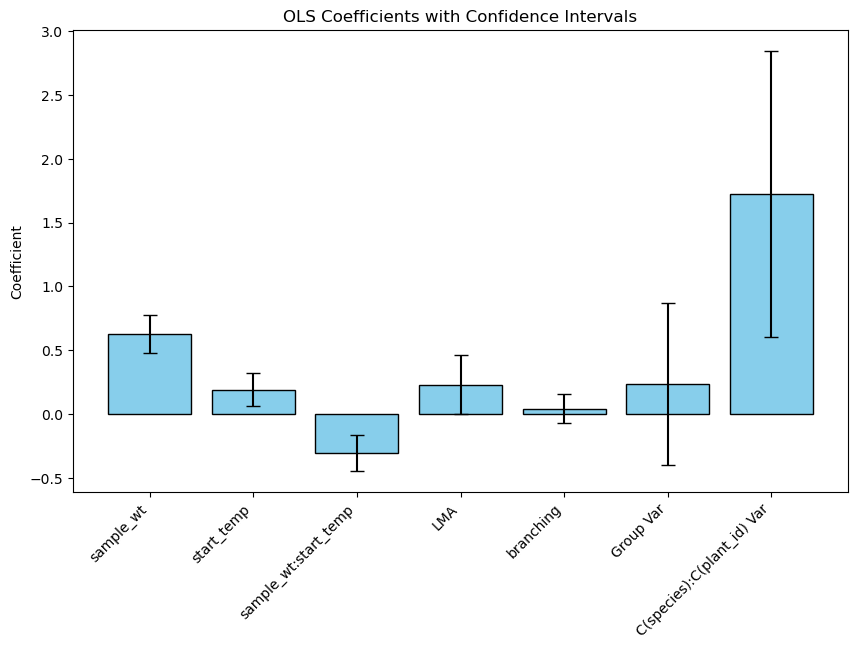

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2073          
Min. group size:     8         Log-Likelihood:       -145.9842       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.096    0.137 -0.704 0.481 -0.365  0.172
sample_wt                   0.639    0.073  8.705 0.000  0.495  0.783
start_temp                  0.186    0.066  2.795 0.005  0.056  0.316
sample_wt:start_temp       -0.310    0.071 -4.338 0.000 -0.450 -0.170
lfm                        -0.077   

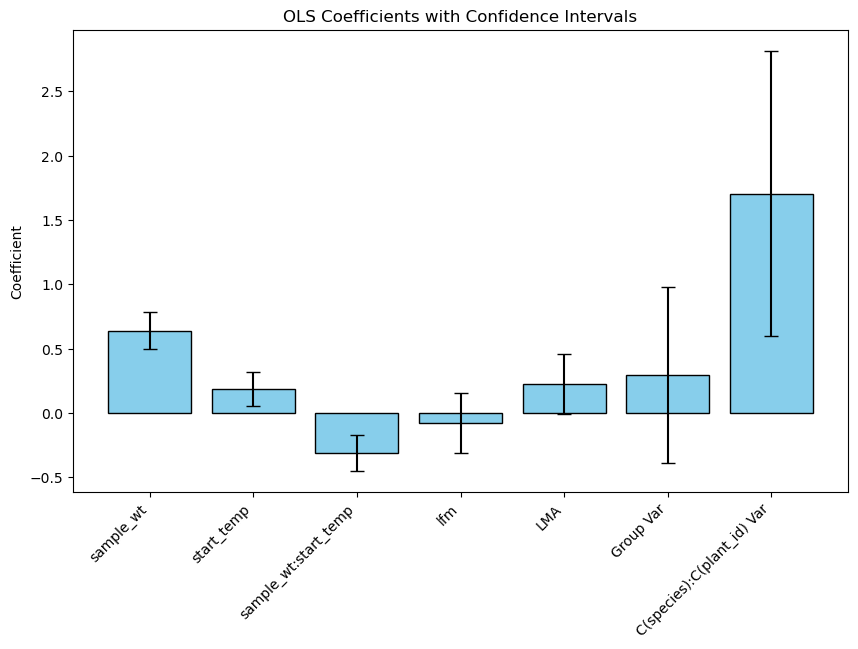

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2069          
Min. group size:     8         Log-Likelihood:       -146.0682       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.093    0.136 -0.681 0.496 -0.360  0.174
sample_wt                   0.650    0.074  8.805 0.000  0.505  0.794
start_temp                  0.189    0.067  2.826 0.005  0.058  0.319
sample_wt:start_temp       -0.309    0.072 -4.320 0.000 -0.450 -0.169
LMA                         0.235   

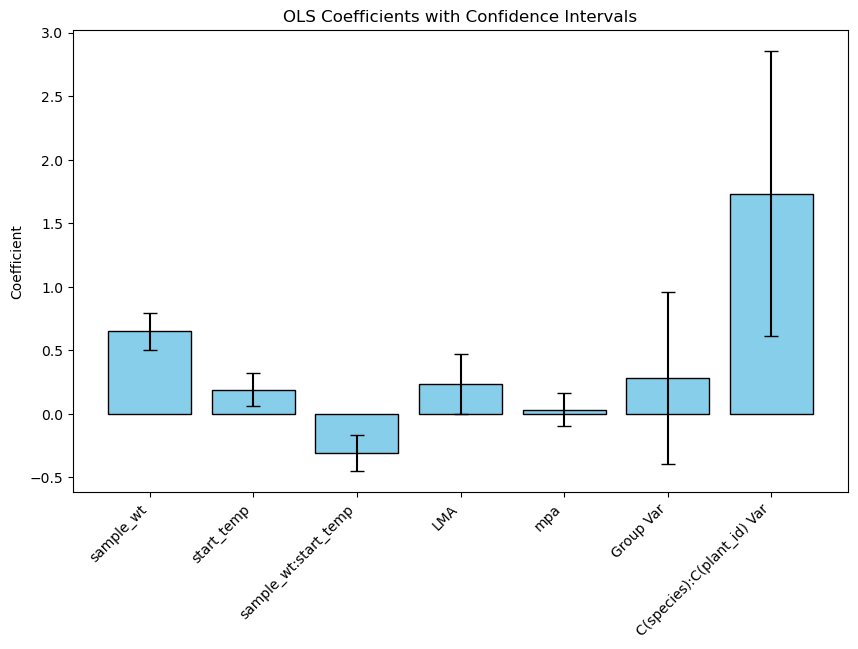

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2073          
Min. group size:     8         Log-Likelihood:       -146.1715       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.095    0.137 -0.689 0.491 -0.363  0.174
sample_wt                   0.642    0.074  8.692 0.000  0.497  0.787
start_temp                  0.191    0.070  2.712 0.007  0.053  0.329
sample_wt:start_temp       -0.312    0.071 -4.363 0.000 -0.452 -0.172
LMA                         0.236   

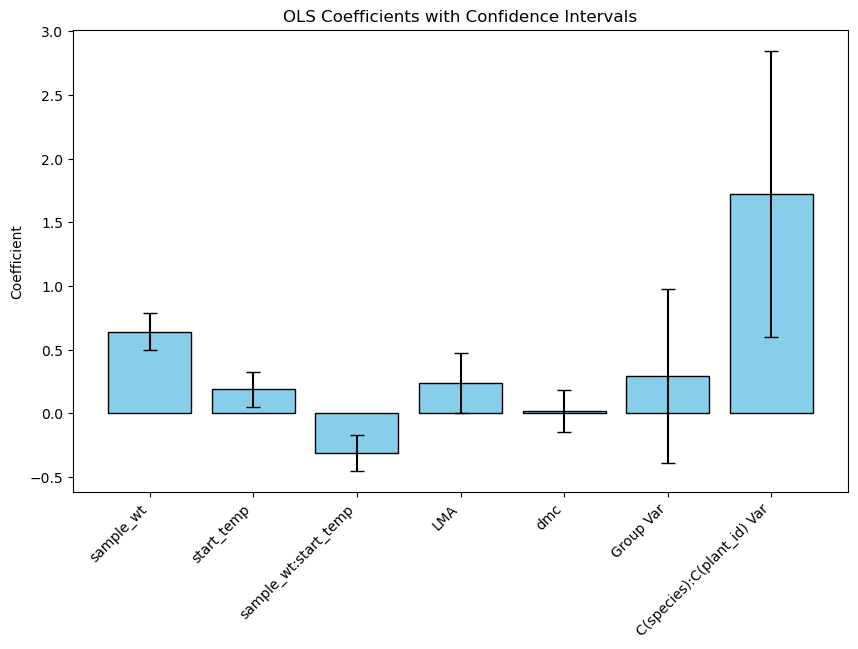

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2150          
Min. group size:     8         Log-Likelihood:       -148.1793       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.068    0.152 -0.447 0.655 -0.366  0.230
sample_wt                   0.702    0.068 10.384 0.000  0.569  0.834
start_temp                  0.177    0.067  2.628 0.009  0.045  0.309
sample_wt:start_temp       -0.304    0.072 -4.210 0.000 -0.445 -0.162
Group Var                   0.092   

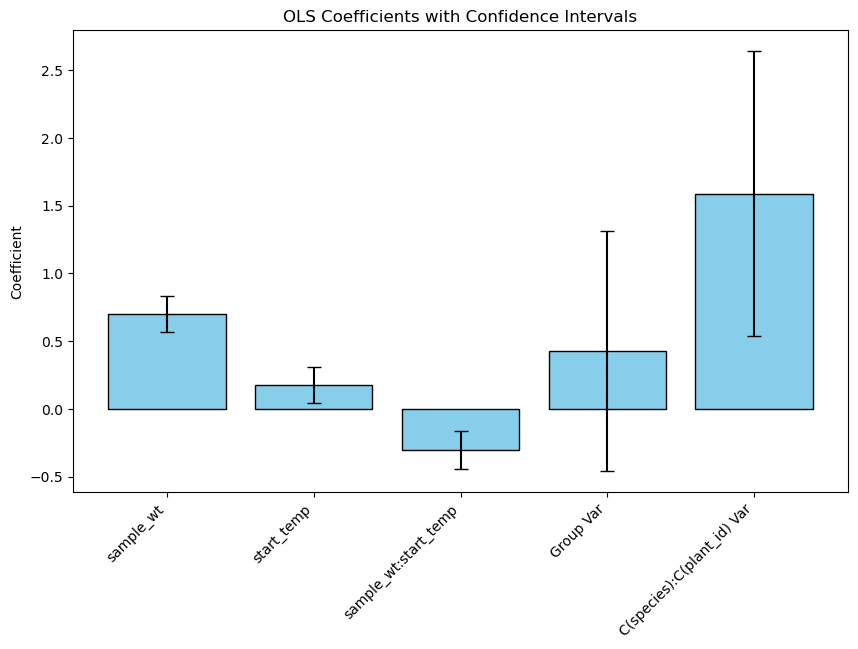

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2150          
Min. group size:     8         Log-Likelihood:       -148.1793       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.068    0.152 -0.447 0.655 -0.366  0.230
sample_wt                   0.702    0.068 10.384 0.000  0.569  0.834
start_temp                  0.177    0.067  2.628 0.009  0.045  0.309
sample_wt:start_temp       -0.304    0.072 -4.210 0.000 -0.445 -0.162
Group Var                   0.092   

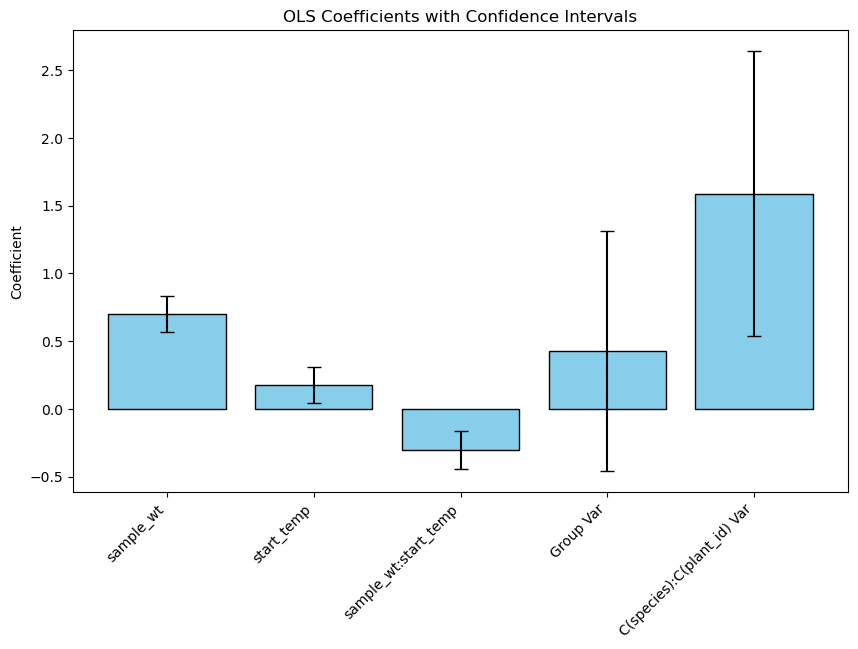

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2079          
Min. group size:     8         Log-Likelihood:       -146.1901       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.094    0.136 -0.691 0.490 -0.360  0.173
sample_wt                   0.653    0.098  6.674 0.000  0.461  0.845
start_temp                  0.188    0.068  2.747 0.006  0.054  0.321
sample_wt:start_temp       -0.306    0.085 -3.610 0.000 -0.473 -0.140
LMA                         0.240   

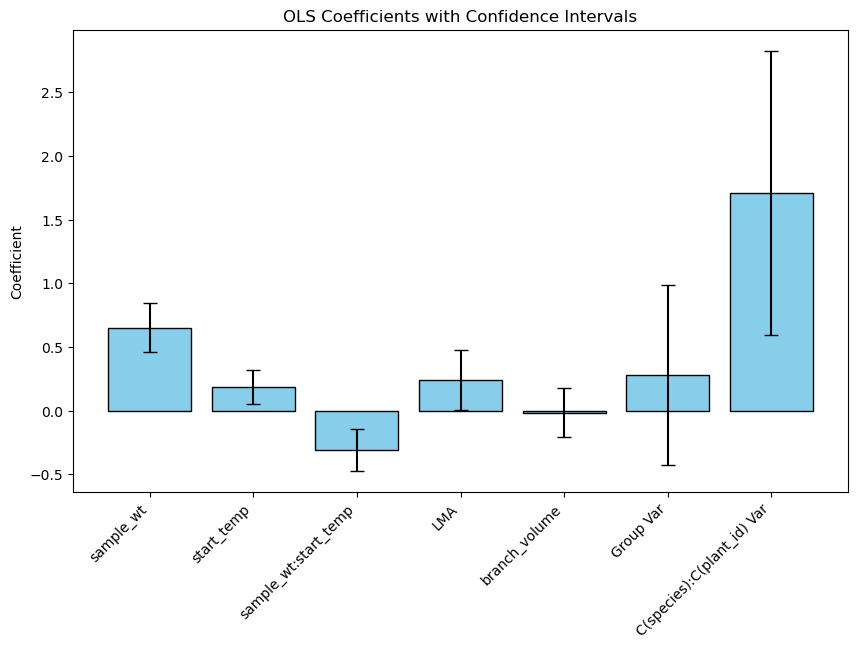

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   heat_flux_change
No. Observations:    158       Method:               ML              
No. Groups:          7         Scale:                0.2075          
Min. group size:     8         Log-Likelihood:       -146.1970       
Max. group size:     37        Converged:            Yes             
Mean group size:     22.6                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.095    0.137 -0.688 0.492 -0.364  0.175
sample_wt                   0.645    0.074  8.761 0.000  0.501  0.789
start_temp                  0.185    0.069  2.684 0.007  0.050  0.319
sample_wt:start_temp       -0.313    0.072 -4.370 0.000 -0.454 -0.173
LMA                         0.241   

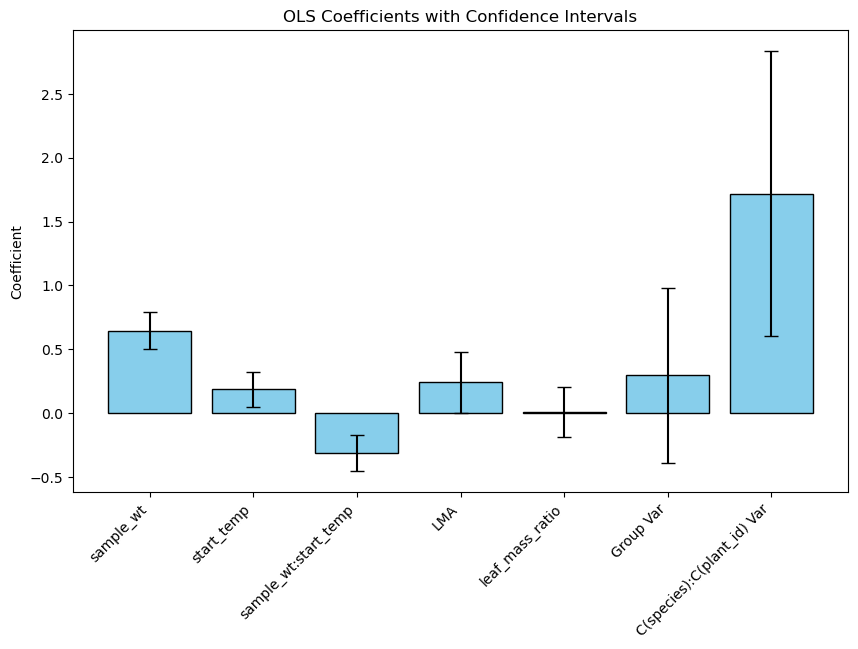

In [15]:
AIC_iterator(flam, cols_use, Y_VAR='heat_flux_change',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)